<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Marcelo Rojas B.
- Nombre de alumno 2: Sebastián Sanhueza O.


### **Link de repositorio de GitHub:** `https://github.com/Marcelorojasb/MDS7202`

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [ ]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.utils import resample

In [ ]:
# Carga de datos
df = pd.read_csv('diabetes_data.csv')
df.head(5)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


Se investigó acerca del dataset, con lo que se obtuvo la siguiente explicación de las variables:

- **Age**: Categoría de edad de 13 niveles organizada en intervalos de 5 años: 1 = 18-24; 2 = 25-29; ...; 9 = 60-64; ...; 13 = 80 o más.
- **Sex**: género del paciente: 1 = masculino; 0 = femenino.
- **HighChol**: 0 = no tiene alto colesterol; 1 = alto colesterol.
- **CholCheck**: 0 = no se ha verificado el colesterol en 5 años; 1 = sí se ha verificado el colesterol en 5 años.
- **BMI**: Índice de Masa Corporal.
- **Smoker**: ¿Has fumado al menos 100 cigarrillos en toda tu vida? (Nota: 5 paquetes = 100 cigarrillos) 0 = no; 1 = sí.
- **HeartDiseaseorAttack**: enfermedad coronaria (CHD) o infarto de miocardio (MI) 0 = no; 1 = sí.
- **PhysActivity**:  actividad física en los últimos 30 días - excluyendo el trabajo 0 = no; 1 = sí.
- **Fruits**: ¿Consumes frutas una o más veces al día? 0 = no; 1 = sí.
- **Veggies**: ¿Consumes verduras una o más veces al día? 0 = no; 1 = sí.
- **HvyAlcoholConsump**: (hombres adultos >=14 bebidas por semana y mujeres adultas >=7 bebidas por semana) 0 = no; 1 = sí.
- **GenHlth**: ¿Dirías que en general tu salud es: escala 1-5 1 = excelente; 2 = muy buena; 3 = buena; 4 = regular; 5 = mala.
- **MentHlth**: días de mala salud mental en una escala de 1 a 30 días.
- **PhysHlth**: días de enfermedad física o lesiones en los últimos 30 días en una escala de 1 a 30.
- **DiffWalk**: ¿Tienes dificultades serias para caminar o subir escaleras? 0 = no; 1 = sí.
- **Stroke**: ¿Has tenido alguna vez un accidente cerebrovascular? 0 = no; 1 = sí.
- **HighBP**: 0 = no tiene presión alta; 1 = tiene presión alta.
- **Diabetes**: 0 = no tiene diabetes; 1 = tiene diabetes.

## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?.

**Análisis Exploratorio de los Datos**

Antes de implementar el modelo de clasificación, se llevará a cabo un análisis exhaustivo de los datos. El propósito es comprender las variables presentes, comprender la información que contienen y sus distribuciones. Esto permitirá evaluar la posibilidad de eliminar ciertas variables o aplicar transformaciones, en caso de ser necesarias, para mejorar la calidad de los datos y potenciar el rendimiento del modelo.

In [ ]:
# Dimensiones
df.shape

(70692, 18)

In [ ]:
# Análisis de valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   70692 non-null  float64
 1   Sex                   70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  GenHlth               70692 non-null  float64
 12  MentHlth              70692 non-null  float64
 13  PhysHlth              70692 non-null  float64
 14  DiffWalk              70692 non-null  float64
 15  Stroke             

In [ ]:
# Análisis de métricas y distribuciones de las variables
df.describe()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,8.584055,0.456997,0.525703,0.975259,29.856985,0.475273,0.147810,0.703036,0.611795,0.788774,0.042721,2.837082,3.752037,5.810417,0.252730,0.062171,0.563458,0.500000
std,2.852153,0.498151,0.499342,0.155336,7.113954,0.499392,0.354914,0.456924,0.487345,0.408181,0.202228,1.113565,8.155627,10.062261,0.434581,0.241468,0.495960,0.500004
min,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,1.000000,1.000000,29.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000
75%,11.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000
max,13.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Análisis del balance de clases
df.Diabetes.value_counts()

0.0    35346
1.0    35346
Name: Diabetes, dtype: int64

Según los resultados previos, el dataset contiene 70692 registros y un total de 18 variables. Se nota que muchas de las variables que podrían ser categóricas ya están transformadas, como la variable `Sex`, lo que elimina la necesidad de aplicarles transformaciones adicionales. Además, la edad media de los pacientes registrados supera los 50 años. Se identifican varios atributos como discretos-ordinales o binarios, lo que los hace idóneos para modelos de árboles. Por último, se destaca un buen equilibrio entre las clases de la variable `Diabetes` dentro del dataset.

**División de los datos**

Los datos ya filtrados se distribuirán en un 80% para el conjunto de entrenamiento y un 20% para el conjunto de pruebas.

In [ ]:
# Separación de las variables de interés y las etiquetas de las clases
features = df.drop(columns=['Diabetes'], axis=1)
labels = df.loc[:, 'Diabetes']

# Generación de los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42) # 80% train, 20% test

**Implementación del modelo**

Se aplicará la transformación `MinMaxScaler` a las variables `Age`, `BMI`, `GenHlth`, `MentHlth` y `PhysHlth`, ya que difieren en escala respecto a la mayoría de los datos, presentando valores significativamente más altos. Esta normalización es crucial para garantizar que estas variables no influyan de manera desproporcionada en el modelo debido a su escala distinta.

Además del preprocesamiento mencionado, se realizaron otras etapas en el Análisis Exploratorio de Datos. Esto incluyó un análisis detallado de las distribuciones de las variables y sus correlaciones entre sí, con el propósito de identificar cualquier desequilibrio significativo entre los valores o la presencia de variables con correlaciones bajas respecto a la variable objetivo. A pesar de estas investigaciones, se encontró que el mejor rendimiento del modelo se logró al utilizar todas las variables del conjunto de datos, aplicando también el escalado mencionado previamente.

Para encontrar el mejor modelo, se empleará el paquete `Optuna` para optimizar los hiperparámetros del clasificador. La métrica de evaluación principal será el `AUC` (Área bajo la Curva) de la curva `ROC` (Característica de Operación del Receptor). El objetivo es maximizar el AUC, que indica la capacidad del modelo para distinguir entre clases positivas y negativas, sin importar el umbral de decisión utilizado. Además, se buscará maximizar el `F1-Score` durante la optimización. Esta métrica combina precisión y recall, siendo fundamental en evaluaciones médicas donde la precisión en la detección de enfermedades es esencial. Destaca la capacidad del modelo para diagnósticos precisos, siendo especialmente relevante en problemas como la detección temprana de la diabetes, donde un diagnóstico preciso es crítico para un tratamiento efectivo.

In [ ]:
!pip install -qq xgboost optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00


In [ ]:
import optuna
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
def objective_function(trial):

  # Hiperparámetros para optimizar
  params = {
      "objective": "binary:logistic",
      "eval_metric": "auc",
      "max_depth": trial.suggest_int("max_depth", 3, 8),
      "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
      "subsample": trial.suggest_float("subsample", 0.5, 1.0),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
      "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
      "gamma": trial.suggest_float("gamma", 0, 1),
      "n_estimators": trial.suggest_int("n_estimators", 10, 300),
      }

  # Variables a escalar
  col_to_scale=['Age', 'BMI', 'GenHlth', 'MentHlth','PhysHlth']

  # Transformador para el conjunto de test
  transformer = ColumnTransformer(transformers=[
      ('minmax', MinMaxScaler(), col_to_scale)],
                                  remainder='passthrough',
                                  verbose_feature_names_out=False)

  # Ajuste de transformador en la data de entrenamiento
  # y transformación de la data de test
  transformer.fit(X_train)
  X_test_transformed = transformer.transform(X_test)

  # # Transformador de columnas del pipeline
  col_transformer = ColumnTransformer(transformers=[
      ('minmax', MinMaxScaler(), col_to_scale)],
                                      remainder='passthrough',
                                      verbose_feature_names_out=False)

  # Prunning callback
  pruning_callback = optuna.integration.XGBoostPruningCallback(
      trial, observation_key="validation_0-auc"
      )

  # Configuración del modelo
  model = XGBClassifier(seed=42, **params)

  # Definición del Pipeline
  pipe = Pipeline(steps=[
      ('column_transformer', col_transformer),
      ('classifier', model)
      ])

  # Entrenamiento del modelo
  pipe.fit(
      X_train,
      y_train,
      classifier__eval_set=[(X_test_transformed, y_test)],
      classifier__callbacks=[pruning_callback],
      )

  # Predicción y evaluación del modelo con la métrica de f1-score
  y_pred = pipe.predict(X_test)
  f1 = f1_score(y_test, y_pred, average='weighted')

  return f1

In [ ]:
# Optimización del modelo
seed=42

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(objective_function, timeout=300) # 5 minutos de entrenamiento

[I 2023-11-24 03:38:47,302] A new study created in memory with name: no-name-627a1b95-ce69-4e14-af1b-07e370a2e484
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79245
[1]	validation_0-auc:0.80322
[2]	validation_0-auc:0.81409
[3]	validation_0-auc:0.81777
[4]	validation_0-auc:0.82131
[5]	validation_0-auc:0.82125
[6]	validation_0-auc:0.82116
[7]	validation_0-auc:0.82109
[8]	validation_0-auc:0.82176
[9]	validation_0-auc:0.82145
[10]	validation_0-auc:0.82186
[11]	validation_0-auc:0.82229
[12]	validation_0-auc:0.82226
[13]	validation_0-auc:0.82255
[14]	validation_0-auc:0.82286
[15]	validation_0-auc:0.82323
[16]	validation_0-auc:0.82340
[17]	validation_0-auc:0.82350
[18]	validation_0-auc:0.82388
[19]	validation_0-auc:0.82407
[20]	validation_0-auc:0.82443
[21]	validation_0-auc:0.82475
[22]	validation_0-auc:0.82484
[23]	validation_0-auc:0.82491
[24]	validation_0-auc:0.82508
[25]	validation_0-auc:0.82534


[I 2023-11-24 03:38:48,022] Trial 0 finished with value: 0.7470682589973282 and parameters: {'max_depth': 5, 'learning_rate': 0.07969454818643935, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.15599452033620265, 'n_estimators': 26}. Best is trial 0 with value: 0.7470682589973282.


[0]	validation_0-auc:0.77771


<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-auc:0.81306
[2]	validation_0-auc:0.80701
[3]	validation_0-auc:0.81602
[4]	validation_0-auc:0.81971
[5]	validation_0-auc:0.81934
[6]	validation_0-auc:0.82033
[7]	validation_0-auc:0.82057
[8]	validation_0-auc:0.81914
[9]	validation_0-auc:0.81995
[10]	validation_0-auc:0.82132
[11]	validation_0-auc:0.82130
[12]	validation_0-auc:0.82017
[13]	validation_0-auc:0.82094
[14]	validation_0-auc:0.82176
[15]	validation_0-auc:0.82242
[16]	validation_0-auc:0.82136
[17]	validation_0-auc:0.82172
[18]	validation_0-auc:0.82161
[19]	validation_0-auc:0.82087
[20]	validation_0-auc:0.82106
[21]	validation_0-auc:0.82125
[22]	validation_0-auc:0.82152
[23]	validation_0-auc:0.82173
[24]	validation_0-auc:0.82162
[25]	validation_0-auc:0.82220
[26]	validation_0-auc:0.82266
[27]	validation_0-auc:0.82283
[28]	validation_0-auc:0.82341
[29]	validation_0-auc:0.82342
[30]	validation_0-auc:0.82324
[31]	validation_0-auc:0.82364
[32]	validation_0-auc:0.82332
[33]	validation_0-auc:0.82325
[34]	validation_0-a

[I 2023-11-24 03:38:52,900] Trial 1 finished with value: 0.7478830107218097 and parameters: {'max_depth': 8, 'learning_rate': 0.015930522616241012, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'min_child_weight': 7, 'gamma': 0.8324426408004217, 'n_estimators': 71}. Best is trial 1 with value: 0.7478830107218097.


[0]	validation_0-auc:0.78132


<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-auc:0.79415
[2]	validation_0-auc:0.80558
[3]	validation_0-auc:0.80879
[4]	validation_0-auc:0.81367
[5]	validation_0-auc:0.81297
[6]	validation_0-auc:0.81207
[7]	validation_0-auc:0.81181
[8]	validation_0-auc:0.81270
[9]	validation_0-auc:0.81166
[10]	validation_0-auc:0.81279
[11]	validation_0-auc:0.81380
[12]	validation_0-auc:0.81431
[13]	validation_0-auc:0.81409
[14]	validation_0-auc:0.81413
[15]	validation_0-auc:0.81561
[16]	validation_0-auc:0.81514
[17]	validation_0-auc:0.81490
[18]	validation_0-auc:0.81465
[19]	validation_0-auc:0.81552
[20]	validation_0-auc:0.81530
[21]	validation_0-auc:0.81614
[22]	validation_0-auc:0.81648
[23]	validation_0-auc:0.81630
[24]	validation_0-auc:0.81645
[25]	validation_0-auc:0.81642
[26]	validation_0-auc:0.81646
[27]	validation_0-auc:0.81642
[28]	validation_0-auc:0.81632
[29]	validation_0-auc:0.81608
[30]	validation_0-auc:0.81577
[31]	validation_0-auc:0.81555
[32]	validation_0-auc:0.81564
[33]	validation_0-auc:0.81568
[34]	validation_0-a

[I 2023-11-24 03:38:56,598] Trial 2 finished with value: 0.7406078517844807 and parameters: {'max_depth': 4, 'learning_rate': 0.002327067708383781, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119, 'min_child_weight': 4, 'gamma': 0.2912291401980419, 'n_estimators': 188}. Best is trial 1 with value: 0.7478830107218097.


[0]	validation_0-auc:0.76043
[1]	validation_0-auc:0.77929


<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.79375
[3]	validation_0-auc:0.79788
[4]	validation_0-auc:0.80471
[5]	validation_0-auc:0.80281
[6]	validation_0-auc:0.80212
[7]	validation_0-auc:0.80253
[8]	validation_0-auc:0.80452
[9]	validation_0-auc:0.80308
[10]	validation_0-auc:0.80502
[11]	validation_0-auc:0.80644
[12]	validation_0-auc:0.80687
[13]	validation_0-auc:0.80621
[14]	validation_0-auc:0.80537
[15]	validation_0-auc:0.80730
[16]	validation_0-auc:0.80748
[17]	validation_0-auc:0.80696
[18]	validation_0-auc:0.80683
[19]	validation_0-auc:0.80810
[20]	validation_0-auc:0.80795
[21]	validation_0-auc:0.80891
[22]	validation_0-auc:0.80923
[23]	validation_0-auc:0.80870
[24]	validation_0-auc:0.80911
[25]	validation_0-auc:0.80936
[26]	validation_0-auc:0.80933
[27]	validation_0-auc:0.80890
[28]	validation_0-auc:0.80859
[29]	validation_0-auc:0.80823
[30]	validation_0-auc:0.80818
[31]	validation_0-auc:0.80781
[32]	validation_0-auc:0.80818
[33]	validation_0-auc:0.80825
[34]	validation_0-auc:0.80869
[35]	validation_0-

[I 2023-11-24 03:38:59,560] Trial 3 finished with value: 0.7362168678535991 and parameters: {'max_depth': 3, 'learning_rate': 0.00383962929980417, 'subsample': 0.6831809216468459, 'colsample_bytree': 0.728034992108518, 'min_child_weight': 6, 'gamma': 0.19967378215835974, 'n_estimators': 159}. Best is trial 1 with value: 0.7478830107218097.


[0]	validation_0-auc:0.79904


<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-auc:0.80675
[2]	validation_0-auc:0.80978
[3]	validation_0-auc:0.81608
[4]	validation_0-auc:0.81832
[5]	validation_0-auc:0.81810
[6]	validation_0-auc:0.81840
[7]	validation_0-auc:0.82069
[8]	validation_0-auc:0.81989
[9]	validation_0-auc:0.82032
[10]	validation_0-auc:0.82166
[11]	validation_0-auc:0.82096
[12]	validation_0-auc:0.82038
[13]	validation_0-auc:0.82059
[14]	validation_0-auc:0.82070
[15]	validation_0-auc:0.82107
[16]	validation_0-auc:0.81977
[17]	validation_0-auc:0.82022
[18]	validation_0-auc:0.82054
[19]	validation_0-auc:0.82042
[20]	validation_0-auc:0.81987
[21]	validation_0-auc:0.82011
[22]	validation_0-auc:0.82066
[23]	validation_0-auc:0.82063
[24]	validation_0-auc:0.82092
[25]	validation_0-auc:0.82141
[26]	validation_0-auc:0.82167
[27]	validation_0-auc:0.82236
[28]	validation_0-auc:0.82261
[29]	validation_0-auc:0.82256
[30]	validation_0-auc:0.82234
[31]	validation_0-auc:0.82254
[32]	validation_0-auc:0.82219
[33]	validation_0-auc:0.82209
[34]	validation_0-a

[I 2023-11-24 03:39:08,838] Trial 4 finished with value: 0.7480388152164855 and parameters: {'max_depth': 6, 'learning_rate': 0.001238513729886093, 'subsample': 0.8037724259507192, 'colsample_bytree': 0.5852620618436457, 'min_child_weight': 1, 'gamma': 0.9488855372533332, 'n_estimators': 290}. Best is trial 4 with value: 0.7480388152164855.


[0]	validation_0-auc:0.79947
[1]	validation_0-auc:0.80862
[2]	validation_0-auc:0.81753


<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-auc:0.81956
[4]	validation_0-auc:0.82297
[5]	validation_0-auc:0.82381
[6]	validation_0-auc:0.82337
[7]	validation_0-auc:0.82332
[8]	validation_0-auc:0.82328
[9]	validation_0-auc:0.82332
[10]	validation_0-auc:0.82347
[11]	validation_0-auc:0.82343
[12]	validation_0-auc:0.82309
[13]	validation_0-auc:0.82314
[14]	validation_0-auc:0.82327
[15]	validation_0-auc:0.82381
[16]	validation_0-auc:0.82361
[17]	validation_0-auc:0.82368
[18]	validation_0-auc:0.82372
[19]	validation_0-auc:0.82388
[20]	validation_0-auc:0.82409
[21]	validation_0-auc:0.82430
[22]	validation_0-auc:0.82430
[23]	validation_0-auc:0.82431
[24]	validation_0-auc:0.82433
[25]	validation_0-auc:0.82433
[26]	validation_0-auc:0.82428
[27]	validation_0-auc:0.82429
[28]	validation_0-auc:0.82434
[29]	validation_0-auc:0.82428
[30]	validation_0-auc:0.82425
[31]	validation_0-auc:0.82428
[32]	validation_0-auc:0.82422
[33]	validation_0-auc:0.82445
[34]	validation_0-auc:0.82442
[35]	validation_0-auc:0.82443
[36]	validation_0

[I 2023-11-24 03:39:12,310] Trial 5 finished with value: 0.7460499216737791 and parameters: {'max_depth': 7, 'learning_rate': 0.0040665633135147945, 'subsample': 0.5488360570031919, 'colsample_bytree': 0.8421165132560784, 'min_child_weight': 4, 'gamma': 0.12203823484477883, 'n_estimators': 154}. Best is trial 4 with value: 0.7480388152164855.


[0]	validation_0-auc:0.76043


<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:39:12,500] Trial 6 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),


[0]	validation_0-auc:0.79463


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-auc:0.79864


[I 2023-11-24 03:39:12,734] Trial 7 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:39:12,921] Trial 8 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rat

[0]	validation_0-auc:0.79372
[1]	validation_0-auc:0.80426


[I 2023-11-24 03:39:13,140] Trial 9 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79992
[1]	validation_0-auc:0.80949
[2]	validation_0-auc:0.80780
[3]	validation_0-auc:0.81622
[4]	validation_0-auc:0.82076
[5]	validation_0-auc:0.82110
[6]	validation_0-auc:0.82170
[7]	validation_0-auc:0.82382
[8]	validation_0-auc:0.82323
[9]	validation_0-auc:0.82330
[10]	validation_0-auc:0.82366
[11]	validation_0-auc:0.82350
[12]	validation_0-auc:0.82325
[13]	validation_0-auc:0.82372
[14]	validation_0-auc:0.82401
[15]	validation_0-auc:0.82438
[16]	validation_0-auc:0.82373
[17]	validation_0-auc:0.82411
[18]	validation_0-auc:0.82401
[19]	validation_0-auc:0.82393
[20]	validation_0-auc:0.82344
[21]	validation_0-auc:0.82398
[22]	validation_0-auc:0.82411
[23]	validation_0-auc:0.82399
[24]	validation_0-auc:0.82416
[25]	validation_0-auc:0.82415
[26]	validation_0-auc:0.82437
[27]	validation_0-auc:0.82462
[28]	validation_0-auc:0.82477
[29]	validation_0-auc:0.82466
[30]	validation_0-auc:0.82459
[31]	validation_0-auc:0.82464
[32]	validation_0-auc:0.82456
[33]	validation_0-au

[I 2023-11-24 03:39:20,485] Trial 10 finished with value: 0.7492303742189588 and parameters: {'max_depth': 7, 'learning_rate': 0.0010280029617905616, 'subsample': 0.9847685553939328, 'colsample_bytree': 0.615072880950218, 'min_child_weight': 1, 'gamma': 0.9076647952825175, 'n_estimators': 222}. Best is trial 10 with value: 0.7492303742189588.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80026
[1]	validation_0-auc:0.80953
[2]	validation_0-auc:0.80777


[I 2023-11-24 03:39:21,040] Trial 11 pruned. Trial was pruned at iteration 3.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.77575


[I 2023-11-24 03:39:22,056] Trial 12 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80010
[1]	validation_0-auc:0.80922
[2]	validation_0-auc:0.81150
[3]	validation_0-auc:0.81781
[4]	validation_0-auc:0.82277
[5]	validation_0-auc:0.82238
[6]	validation_0-auc:0.82380
[7]	validation_0-auc:0.82447
[8]	validation_0-auc:0.82379
[9]	validation_0-auc:0.82327
[10]	validation_0-auc:0.82325
[11]	validation_0-auc:0.82317
[12]	validation_0-auc:0.82301
[13]	validation_0-auc:0.82343
[14]	validation_0-auc:0.82373
[15]	validation_0-auc:0.82421
[16]	validation_0-auc:0.82337
[17]	validation_0-auc:0.82376
[18]	validation_0-auc:0.82369
[19]	validation_0-auc:0.82379
[20]	validation_0-auc:0.82337
[21]	validation_0-auc:0.82406
[22]	validation_0-auc:0.82421
[23]	validation_0-auc:0.82435
[24]	validation_0-auc:0.82431
[25]	validation_0-auc:0.82426
[26]	validation_0-auc:0.82443
[27]	validation_0-auc:0.82465
[28]	validation_0-auc:0.82469
[29]	validation_0-auc:0.82459
[30]	validation_0-auc:0.82458
[31]	validation_0-auc:0.82466
[32]	validation_0-auc:0.82466
[33]	validation_0-au

[I 2023-11-24 03:39:24,775] Trial 13 finished with value: 0.7484661953687385 and parameters: {'max_depth': 7, 'learning_rate': 0.0010888052582019767, 'subsample': 0.748020656084857, 'colsample_bytree': 0.6560812011433839, 'min_child_weight': 2, 'gamma': 0.7719295837601932, 'n_estimators': 111}. Best is trial 10 with value: 0.7492303742189588.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79840
[1]	validation_0-auc:0.80887
[2]	validation_0-auc:0.81261
[3]	validation_0-auc:0.81850
[4]	validation_0-auc:0.82314
[5]	validation_0-auc:0.82305
[6]	validation_0-auc:0.82465
[7]	validation_0-auc:0.82540
[8]	validation_0-auc:0.82478
[9]	validation_0-auc:0.82442
[10]	validation_0-auc:0.82451
[11]	validation_0-auc:0.82454
[12]	validation_0-auc:0.82442
[13]	validation_0-auc:0.82486
[14]	validation_0-auc:0.82522
[15]	validation_0-auc:0.82559
[16]	validation_0-auc:0.82487
[17]	validation_0-auc:0.82524
[18]	validation_0-auc:0.82519
[19]	validation_0-auc:0.82528
[20]	validation_0-auc:0.82487
[21]	validation_0-auc:0.82546
[22]	validation_0-auc:0.82557
[23]	validation_0-auc:0.82570
[24]	validation_0-auc:0.82571
[25]	validation_0-auc:0.82566
[26]	validation_0-auc:0.82586
[27]	validation_0-auc:0.82604
[28]	validation_0-auc:0.82619
[29]	validation_0-auc:0.82612
[30]	validation_0-auc:0.82604
[31]	validation_0-auc:0.82609
[32]	validation_0-auc:0.82603
[33]	validation_0-au

[I 2023-11-24 03:39:27,227] Trial 14 finished with value: 0.7507153285455644 and parameters: {'max_depth': 8, 'learning_rate': 0.008186282230228674, 'subsample': 0.7202206491554037, 'colsample_bytree': 0.6682809939439037, 'min_child_weight': 2, 'gamma': 0.723467158661015, 'n_estimators': 102}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79969
[1]	validation_0-auc:0.81067
[2]	validation_0-auc:0.81938
[3]	validation_0-auc:0.82125
[4]	validation_0-auc:0.82456
[5]	validation_0-auc:0.82426
[6]	validation_0-auc:0.82441
[7]	validation_0-auc:0.82460
[8]	validation_0-auc:0.82453
[9]	validation_0-auc:0.82423
[10]	validation_0-auc:0.82451
[11]	validation_0-auc:0.82469
[12]	validation_0-auc:0.82458
[13]	validation_0-auc:0.82484
[14]	validation_0-auc:0.82496
[15]	validation_0-auc:0.82538
[16]	validation_0-auc:0.82486
[17]	validation_0-auc:0.82507
[18]	validation_0-auc:0.82502
[19]	validation_0-auc:0.82523
[20]	validation_0-auc:0.82490
[21]	validation_0-auc:0.82538
[22]	validation_0-auc:0.82555
[23]	validation_0-auc:0.82565
[24]	validation_0-auc:0.82568
[25]	validation_0-auc:0.82559
[26]	validation_0-auc:0.82572
[27]	validation_0-auc:0.82591
[28]	validation_0-auc:0.82604
[29]	validation_0-auc:0.82603
[30]	validation_0-auc:0.82601
[31]	validation_0-auc:0.82603
[32]	validation_0-auc:0.82597
[33]	validation_0-au

[I 2023-11-24 03:39:29,919] Trial 15 finished with value: 0.7491023728978298 and parameters: {'max_depth': 8, 'learning_rate': 0.00872274132467676, 'subsample': 0.9323982934150861, 'colsample_bytree': 0.7091568361777469, 'min_child_weight': 2, 'gamma': 0.7294810066472612, 'n_estimators': 108}. Best is trial 14 with value: 0.7507153285455644.


[0]	validation_0-auc:0.79783


<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:39:30,125] Trial 16 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:

[0]	validation_0-auc:0.79987
[1]	validation_0-auc:0.80910
[2]	validation_0-auc:0.81154
[3]	validation_0-auc:0.81790
[4]	validation_0-auc:0.82277
[5]	validation_0-auc:0.82254
[6]	validation_0-auc:0.82433
[7]	validation_0-auc:0.82498
[8]	validation_0-auc:0.82445
[9]	validation_0-auc:0.82399
[10]	validation_0-auc:0.82395
[11]	validation_0-auc:0.82396
[12]	validation_0-auc:0.82394
[13]	validation_0-auc:0.82425
[14]	validation_0-auc:0.82458
[15]	validation_0-auc:0.82491
[16]	validation_0-auc:0.82431
[17]	validation_0-auc:0.82453
[18]	validation_0-auc:0.82445
[19]	validation_0-auc:0.82456
[20]	validation_0-auc:0.82426
[21]	validation_0-auc:0.82483
[22]	validation_0-auc:0.82496
[23]	validation_0-auc:0.82508
[24]	validation_0-auc:0.82515
[25]	validation_0-auc:0.82515
[26]	validation_0-auc:0.82527
[27]	validation_0-auc:0.82543
[28]	validation_0-auc:0.82558
[29]	validation_0-auc:0.82559
[30]	validation_0-auc:0.82562
[31]	validation_0-auc:0.82565
[32]	validation_0-auc:0.82563
[33]	validation_0-au

[I 2023-11-24 03:39:34,240] Trial 17 finished with value: 0.7472631896605934 and parameters: {'max_depth': 7, 'learning_rate': 0.024668365485873183, 'subsample': 0.8091127204663657, 'colsample_bytree': 0.6875028992249247, 'min_child_weight': 2, 'gamma': 0.8492071929191394, 'n_estimators': 51}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79919
[1]	validation_0-auc:0.80923
[2]	validation_0-auc:0.80817


[I 2023-11-24 03:39:35,821] Trial 18 pruned. Trial was pruned at iteration 2.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:39:36,856] Trial 19 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.80086
[1]	validation_0-auc:0.80890


[I 2023-11-24 03:39:37,851] Trial 20 pruned. Trial was pruned at iteration 2.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79933
[1]	validation_0-auc:0.81018
[2]	validation_0-auc:0.81895
[3]	validation_0-auc:0.82096
[4]	validation_0-auc:0.82427
[5]	validation_0-auc:0.82401
[6]	validation_0-auc:0.82432
[7]	validation_0-auc:0.82439
[8]	validation_0-auc:0.82443
[9]	validation_0-auc:0.82413
[10]	validation_0-auc:0.82444
[11]	validation_0-auc:0.82458
[12]	validation_0-auc:0.82442
[13]	validation_0-auc:0.82468
[14]	validation_0-auc:0.82481
[15]	validation_0-auc:0.82527
[16]	validation_0-auc:0.82474
[17]	validation_0-auc:0.82498
[18]	validation_0-auc:0.82491
[19]	validation_0-auc:0.82511
[20]	validation_0-auc:0.82479
[21]	validation_0-auc:0.82525
[22]	validation_0-auc:0.82543
[23]	validation_0-auc:0.82553
[24]	validation_0-auc:0.82558
[25]	validation_0-auc:0.82552
[26]	validation_0-auc:0.82573
[27]	validation_0-auc:0.82587
[28]	validation_0-auc:0.82600
[29]	validation_0-auc:0.82604
[30]	validation_0-auc:0.82602
[31]	validation_0-auc:0.82603
[32]	validation_0-auc:0.82595
[33]	validation_0-au

[I 2023-11-24 03:39:45,976] Trial 21 finished with value: 0.7486229329794363 and parameters: {'max_depth': 8, 'learning_rate': 0.009763947804298631, 'subsample': 0.9472192829345127, 'colsample_bytree': 0.7073458527446985, 'min_child_weight': 2, 'gamma': 0.7447899930585594, 'n_estimators': 97}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79930
[1]	validation_0-auc:0.80956
[2]	validation_0-auc:0.81234
[3]	validation_0-auc:0.81831
[4]	validation_0-auc:0.82296
[5]	validation_0-auc:0.82255
[6]	validation_0-auc:0.82425
[7]	validation_0-auc:0.82509
[8]	validation_0-auc:0.82451
[9]	validation_0-auc:0.82414
[10]	validation_0-auc:0.82423
[11]	validation_0-auc:0.82412
[12]	validation_0-auc:0.82390
[13]	validation_0-auc:0.82438
[14]	validation_0-auc:0.82461
[15]	validation_0-auc:0.82503
[16]	validation_0-auc:0.82428
[17]	validation_0-auc:0.82466
[18]	validation_0-auc:0.82455
[19]	validation_0-auc:0.82457
[20]	validation_0-auc:0.82413
[21]	validation_0-auc:0.82475
[22]	validation_0-auc:0.82493
[23]	validation_0-auc:0.82510
[24]	validation_0-auc:0.82504
[25]	validation_0-auc:0.82499
[26]	validation_0-auc:0.82517
[27]	validation_0-auc:0.82541
[28]	validation_0-auc:0.82561
[29]	validation_0-auc:0.82555
[30]	validation_0-auc:0.82555
[31]	validation_0-auc:0.82562
[32]	validation_0-auc:0.82557
[33]	validation_0-au

[I 2023-11-24 03:39:59,163] Trial 22 finished with value: 0.749660097666989 and parameters: {'max_depth': 8, 'learning_rate': 0.002068523578975651, 'subsample': 0.9371911254171804, 'colsample_bytree': 0.701787274527496, 'min_child_weight': 2, 'gamma': 0.7366623556228177, 'n_estimators': 129}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79970
[1]	validation_0-auc:0.81043
[2]	validation_0-auc:0.81930
[3]	validation_0-auc:0.82123
[4]	validation_0-auc:0.82452
[5]	validation_0-auc:0.82418
[6]	validation_0-auc:0.82439
[7]	validation_0-auc:0.82447
[8]	validation_0-auc:0.82451
[9]	validation_0-auc:0.82428
[10]	validation_0-auc:0.82457
[11]	validation_0-auc:0.82460
[12]	validation_0-auc:0.82446
[13]	validation_0-auc:0.82464
[14]	validation_0-auc:0.82480
[15]	validation_0-auc:0.82527
[16]	validation_0-auc:0.82469
[17]	validation_0-auc:0.82486
[18]	validation_0-auc:0.82478
[19]	validation_0-auc:0.82495
[20]	validation_0-auc:0.82456
[21]	validation_0-auc:0.82509
[22]	validation_0-auc:0.82528
[23]	validation_0-auc:0.82533
[24]	validation_0-auc:0.82538
[25]	validation_0-auc:0.82528
[26]	validation_0-auc:0.82543
[27]	validation_0-auc:0.82563
[28]	validation_0-auc:0.82575
[29]	validation_0-auc:0.82580
[30]	validation_0-auc:0.82574
[31]	validation_0-auc:0.82576
[32]	validation_0-auc:0.82567
[33]	validation_0-au

[I 2023-11-24 03:40:09,404] Trial 23 finished with value: 0.7487187424421675 and parameters: {'max_depth': 8, 'learning_rate': 0.0019702562749291355, 'subsample': 0.9567174267416829, 'colsample_bytree': 0.7551881412101857, 'min_child_weight': 1, 'gamma': 0.8819997489520147, 'n_estimators': 133}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80000
[1]	validation_0-auc:0.80864


[I 2023-11-24 03:40:09,673] Trial 24 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79920


[I 2023-11-24 03:40:09,933] Trial 25 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80036
[1]	validation_0-auc:0.80926


[I 2023-11-24 03:40:10,242] Trial 26 pruned. Trial was pruned at iteration 2.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:40:10,488] Trial 27 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.80134
[1]	validation_0-auc:0.81029
[2]	validation_0-auc:0.81795
[3]	validation_0-auc:0.81995
[4]	validation_0-auc:0.82398
[5]	validation_0-auc:0.82364
[6]	validation_0-auc:0.82356
[7]	validation_0-auc:0.82341


[I 2023-11-24 03:40:11,143] Trial 29 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:40:11,371] Trial 30 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.79968
[1]	validation_0-auc:0.81072
[2]	validation_0-auc:0.81945
[3]	validation_0-auc:0.82121
[4]	validation_0-auc:0.82446
[5]	validation_0-auc:0.82414
[6]	validation_0-auc:0.82446
[7]	validation_0-auc:0.82460
[8]	validation_0-auc:0.82453
[9]	validation_0-auc:0.82416
[10]	validation_0-auc:0.82443
[11]	validation_0-auc:0.82453
[12]	validation_0-auc:0.82440
[13]	validation_0-auc:0.82469
[14]	validation_0-auc:0.82479
[15]	validation_0-auc:0.82521
[16]	validation_0-auc:0.82467
[17]	validation_0-auc:0.82489
[18]	validation_0-auc:0.82481
[19]	validation_0-auc:0.82504
[20]	validation_0-auc:0.82470
[21]	validation_0-auc:0.82521
[22]	validation_0-auc:0.82538
[23]	validation_0-auc:0.82547
[24]	validation_0-auc:0.82548
[25]	validation_0-auc:0.82541
[26]	validation_0-auc:0.82555
[27]	validation_0-auc:0.82571
[28]	validation_0-auc:0.82584
[29]	validation_0-auc:0.82586
[30]	validation_0-auc:0.82583
[31]	validation_0-auc:0.82586
[32]	validation_0-auc:0.82576
[33]	validation_0-au

[I 2023-11-24 03:40:13,779] Trial 31 finished with value: 0.7483183969011328 and parameters: {'max_depth': 8, 'learning_rate': 0.004927031950770791, 'subsample': 0.9319951650438629, 'colsample_bytree': 0.7116928344325613, 'min_child_weight': 2, 'gamma': 0.7177861330745053, 'n_estimators': 98}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:40:13,973] Trial 32 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14f

[0]	validation_0-auc:0.79962
[1]	validation_0-auc:0.81005
[2]	validation_0-auc:0.81894
[3]	validation_0-auc:0.82084
[4]	validation_0-auc:0.82425
[5]	validation_0-auc:0.82380
[6]	validation_0-auc:0.82395


[I 2023-11-24 03:40:14,353] Trial 33 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79861


[I 2023-11-24 03:40:14,562] Trial 34 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80067
[1]	validation_0-auc:0.80946
[2]	validation_0-auc:0.80762


[I 2023-11-24 03:40:14,821] Trial 35 pruned. Trial was pruned at iteration 2.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:40:15,046] Trial 36 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.79961
[1]	validation_0-auc:0.80941
[2]	validation_0-auc:0.81754
[3]	validation_0-auc:0.82004
[4]	validation_0-auc:0.82382
[5]	validation_0-auc:0.82329
[6]	validation_0-auc:0.82332


[I 2023-11-24 03:40:15,390] Trial 37 pruned. Trial was pruned at iteration 7.


[0]	validation_0-auc:0.78393


<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:40:15,589] Trial 38 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:

[0]	validation_0-auc:0.80029
[1]	validation_0-auc:0.81169
[2]	validation_0-auc:0.81976
[3]	validation_0-auc:0.82145
[4]	validation_0-auc:0.82485
[5]	validation_0-auc:0.82451
[6]	validation_0-auc:0.82452
[7]	validation_0-auc:0.82454
[8]	validation_0-auc:0.82497
[9]	validation_0-auc:0.82488
[10]	validation_0-auc:0.82498
[11]	validation_0-auc:0.82498
[12]	validation_0-auc:0.82477
[13]	validation_0-auc:0.82480
[14]	validation_0-auc:0.82484
[15]	validation_0-auc:0.82512
[16]	validation_0-auc:0.82477
[17]	validation_0-auc:0.82483
[18]	validation_0-auc:0.82501
[19]	validation_0-auc:0.82523
[20]	validation_0-auc:0.82530
[21]	validation_0-auc:0.82556
[22]	validation_0-auc:0.82560
[23]	validation_0-auc:0.82558
[24]	validation_0-auc:0.82563
[25]	validation_0-auc:0.82566
[26]	validation_0-auc:0.82564
[27]	validation_0-auc:0.82572
[28]	validation_0-auc:0.82571
[29]	validation_0-auc:0.82572
[30]	validation_0-auc:0.82563
[31]	validation_0-auc:0.82561
[32]	validation_0-auc:0.82556
[33]	validation_0-au

[I 2023-11-24 03:40:29,372] Trial 39 finished with value: 0.7495722873545003 and parameters: {'max_depth': 8, 'learning_rate': 0.007431847975848796, 'subsample': 0.871146832198424, 'colsample_bytree': 0.773086107839667, 'min_child_weight': 1, 'gamma': 0.9206323965329068, 'n_estimators': 207}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:40:30,306] Trial 40 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa

[0]	validation_0-auc:0.79951
[1]	validation_0-auc:0.81038
[2]	validation_0-auc:0.81914
[3]	validation_0-auc:0.82126
[4]	validation_0-auc:0.82428
[5]	validation_0-auc:0.82407
[6]	validation_0-auc:0.82440
[7]	validation_0-auc:0.82444
[8]	validation_0-auc:0.82442
[9]	validation_0-auc:0.82425
[10]	validation_0-auc:0.82449
[11]	validation_0-auc:0.82457
[12]	validation_0-auc:0.82451
[13]	validation_0-auc:0.82477
[14]	validation_0-auc:0.82482
[15]	validation_0-auc:0.82528
[16]	validation_0-auc:0.82477
[17]	validation_0-auc:0.82496
[18]	validation_0-auc:0.82488
[19]	validation_0-auc:0.82502
[20]	validation_0-auc:0.82471
[21]	validation_0-auc:0.82522
[22]	validation_0-auc:0.82541
[23]	validation_0-auc:0.82551
[24]	validation_0-auc:0.82552
[25]	validation_0-auc:0.82544
[26]	validation_0-auc:0.82559
[27]	validation_0-auc:0.82576
[28]	validation_0-auc:0.82586
[29]	validation_0-auc:0.82579
[30]	validation_0-auc:0.82580
[31]	validation_0-auc:0.82581
[32]	validation_0-auc:0.82578
[33]	validation_0-au

[I 2023-11-24 03:40:47,584] Trial 41 finished with value: 0.7505164552362488 and parameters: {'max_depth': 8, 'learning_rate': 0.008366268382951887, 'subsample': 0.9136842274563618, 'colsample_bytree': 0.7374821279913889, 'min_child_weight': 1, 'gamma': 0.8551761141285555, 'n_estimators': 203}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79915


[I 2023-11-24 03:40:49,115] Trial 42 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79933


[I 2023-11-24 03:40:50,698] Trial 43 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80036
[1]	validation_0-auc:0.81011
[2]	validation_0-auc:0.81784
[3]	validation_0-auc:0.81974
[4]	validation_0-auc:0.82360
[5]	validation_0-auc:0.82343
[6]	validation_0-auc:0.82337


[I 2023-11-24 03:40:52,430] Trial 44 pruned. Trial was pruned at iteration 6.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),


[0]	validation_0-auc:0.80174


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-auc:0.81015
[2]	validation_0-auc:0.81793
[3]	validation_0-auc:0.82030
[4]	validation_0-auc:0.82323
[5]	validation_0-auc:0.82348


[I 2023-11-24 03:40:53,138] Trial 45 pruned. Trial was pruned at iteration 6.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:40:53,447] Trial 46 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.79897


[I 2023-11-24 03:40:53,704] Trial 47 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80039
[1]	validation_0-auc:0.81034
[2]	validation_0-auc:0.81845
[3]	validation_0-auc:0.82020
[4]	validation_0-auc:0.82392
[5]	validation_0-auc:0.82357


[I 2023-11-24 03:40:54,236] Trial 48 pruned. Trial was pruned at iteration 6.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80089
[1]	validation_0-auc:0.81059
[2]	validation_0-auc:0.81867
[3]	validation_0-auc:0.82039
[4]	validation_0-auc:0.82431
[5]	validation_0-auc:0.82388
[6]	validation_0-auc:0.82364
[7]	validation_0-auc:0.82359


[I 2023-11-24 03:40:55,632] Trial 49 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79885


[I 2023-11-24 03:40:56,876] Trial 50 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79978
[1]	validation_0-auc:0.81049
[2]	validation_0-auc:0.81914
[3]	validation_0-auc:0.82104
[4]	validation_0-auc:0.82424
[5]	validation_0-auc:0.82392
[6]	validation_0-auc:0.82417


[I 2023-11-24 03:40:57,714] Trial 51 pruned. Trial was pruned at iteration 6.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:40:58,410] Trial 52 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.79998
[1]	validation_0-auc:0.81050
[2]	validation_0-auc:0.81926
[3]	validation_0-auc:0.82107
[4]	validation_0-auc:0.82425
[5]	validation_0-auc:0.82392


[I 2023-11-24 03:40:59,477] Trial 53 pruned. Trial was pruned at iteration 6.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80023
[1]	validation_0-auc:0.80929


[I 2023-11-24 03:41:00,247] Trial 54 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79955


[I 2023-11-24 03:41:00,813] Trial 55 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.78350


[I 2023-11-24 03:41:01,303] Trial 56 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79967
[1]	validation_0-auc:0.81053
[2]	validation_0-auc:0.81932
[3]	validation_0-auc:0.82135
[4]	validation_0-auc:0.82436
[5]	validation_0-auc:0.82408
[6]	validation_0-auc:0.82422


[I 2023-11-24 03:41:01,964] Trial 57 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80077
[1]	validation_0-auc:0.80868


[I 2023-11-24 03:41:02,215] Trial 58 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:02,435] Trial 59 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.80120
[1]	validation_0-auc:0.80949


[I 2023-11-24 03:41:02,692] Trial 60 pruned. Trial was pruned at iteration 2.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80014
[1]	validation_0-auc:0.81068
[2]	validation_0-auc:0.81952
[3]	validation_0-auc:0.82147
[4]	validation_0-auc:0.82466
[5]	validation_0-auc:0.82428
[6]	validation_0-auc:0.82454
[7]	validation_0-auc:0.82461
[8]	validation_0-auc:0.82458
[9]	validation_0-auc:0.82432
[10]	validation_0-auc:0.82461
[11]	validation_0-auc:0.82462
[12]	validation_0-auc:0.82446
[13]	validation_0-auc:0.82470
[14]	validation_0-auc:0.82479
[15]	validation_0-auc:0.82527
[16]	validation_0-auc:0.82469
[17]	validation_0-auc:0.82489
[18]	validation_0-auc:0.82478
[19]	validation_0-auc:0.82496
[20]	validation_0-auc:0.82454
[21]	validation_0-auc:0.82509
[22]	validation_0-auc:0.82529
[23]	validation_0-auc:0.82534
[24]	validation_0-auc:0.82539
[25]	validation_0-auc:0.82529
[26]	validation_0-auc:0.82544
[27]	validation_0-auc:0.82564
[28]	validation_0-auc:0.82578
[29]	validation_0-auc:0.82583
[30]	validation_0-auc:0.82576
[31]	validation_0-auc:0.82576
[32]	validation_0-auc:0.82565
[33]	validation_0-au

[I 2023-11-24 03:41:09,454] Trial 61 finished with value: 0.7487823229582732 and parameters: {'max_depth': 8, 'learning_rate': 0.0012082694673650179, 'subsample': 0.9557189029043249, 'colsample_bytree': 0.7546756883922834, 'min_child_weight': 1, 'gamma': 0.8843750070815402, 'n_estimators': 133}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79992
[1]	validation_0-auc:0.81066
[2]	validation_0-auc:0.81907
[3]	validation_0-auc:0.82098
[4]	validation_0-auc:0.82444
[5]	validation_0-auc:0.82406
[6]	validation_0-auc:0.82417
[7]	validation_0-auc:0.82424


[I 2023-11-24 03:41:09,887] Trial 62 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79978
[1]	validation_0-auc:0.81019
[2]	validation_0-auc:0.81885
[3]	validation_0-auc:0.82104
[4]	validation_0-auc:0.82439
[5]	validation_0-auc:0.82409
[6]	validation_0-auc:0.82413
[7]	validation_0-auc:0.82423


[I 2023-11-24 03:41:10,323] Trial 63 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:10,566] Trial 64 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.79908


[I 2023-11-24 03:41:11,350] Trial 67 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80022


[I 2023-11-24 03:41:11,645] Trial 68 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:11,903] Trial 69 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.79274


[I 2023-11-24 03:41:12,152] Trial 70 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80005
[1]	validation_0-auc:0.81066
[2]	validation_0-auc:0.81917
[3]	validation_0-auc:0.82118
[4]	validation_0-auc:0.82444
[5]	validation_0-auc:0.82408
[6]	validation_0-auc:0.82423
[7]	validation_0-auc:0.82437


[I 2023-11-24 03:41:12,594] Trial 71 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80001
[1]	validation_0-auc:0.81116
[2]	validation_0-auc:0.81930
[3]	validation_0-auc:0.82089
[4]	validation_0-auc:0.82437
[5]	validation_0-auc:0.82414
[6]	validation_0-auc:0.82437


[I 2023-11-24 03:41:13,037] Trial 72 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79978
[1]	validation_0-auc:0.81062
[2]	validation_0-auc:0.81940
[3]	validation_0-auc:0.82139
[4]	validation_0-auc:0.82447
[5]	validation_0-auc:0.82414
[6]	validation_0-auc:0.82431
[7]	validation_0-auc:0.82437
[8]	validation_0-auc:0.82421
[9]	validation_0-auc:0.82400
[10]	validation_0-auc:0.82427
[11]	validation_0-auc:0.82429
[12]	validation_0-auc:0.82417
[13]	validation_0-auc:0.82443


[I 2023-11-24 03:41:13,647] Trial 73 pruned. Trial was pruned at iteration 14.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80050
[1]	validation_0-auc:0.81131
[2]	validation_0-auc:0.81965
[3]	validation_0-auc:0.82131
[4]	validation_0-auc:0.82482
[5]	validation_0-auc:0.82461
[6]	validation_0-auc:0.82453
[7]	validation_0-auc:0.82455
[8]	validation_0-auc:0.82501
[9]	validation_0-auc:0.82490
[10]	validation_0-auc:0.82498
[11]	validation_0-auc:0.82488
[12]	validation_0-auc:0.82458
[13]	validation_0-auc:0.82475
[14]	validation_0-auc:0.82480
[15]	validation_0-auc:0.82506
[16]	validation_0-auc:0.82482
[17]	validation_0-auc:0.82500
[18]	validation_0-auc:0.82512
[19]	validation_0-auc:0.82528
[20]	validation_0-auc:0.82527
[21]	validation_0-auc:0.82552
[22]	validation_0-auc:0.82558
[23]	validation_0-auc:0.82557
[24]	validation_0-auc:0.82566
[25]	validation_0-auc:0.82569
[26]	validation_0-auc:0.82567
[27]	validation_0-auc:0.82570
[28]	validation_0-auc:0.82574
[29]	validation_0-auc:0.82575
[30]	validation_0-auc:0.82566
[31]	validation_0-auc:0.82563
[32]	validation_0-auc:0.82550
[33]	validation_0-au

[I 2023-11-24 03:41:15,565] Trial 74 pruned. Trial was pruned at iteration 71.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79972


[I 2023-11-24 03:41:15,830] Trial 75 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:16,073] Trial 76 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.80074
[1]	validation_0-auc:0.80933


[I 2023-11-24 03:41:16,370] Trial 77 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79943


[I 2023-11-24 03:41:16,627] Trial 78 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79841


[I 2023-11-24 03:41:16,907] Trial 79 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79942


[I 2023-11-24 03:41:17,167] Trial 80 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79919


[I 2023-11-24 03:41:17,422] Trial 81 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79998
[1]	validation_0-auc:0.81068
[2]	validation_0-auc:0.81928
[3]	validation_0-auc:0.82119
[4]	validation_0-auc:0.82445
[5]	validation_0-auc:0.82414
[6]	validation_0-auc:0.82431
[7]	validation_0-auc:0.82449
[8]	validation_0-auc:0.82445
[9]	validation_0-auc:0.82416
[10]	validation_0-auc:0.82445
[11]	validation_0-auc:0.82470
[12]	validation_0-auc:0.82460
[13]	validation_0-auc:0.82484
[14]	validation_0-auc:0.82497
[15]	validation_0-auc:0.82536
[16]	validation_0-auc:0.82485
[17]	validation_0-auc:0.82501
[18]	validation_0-auc:0.82499
[19]	validation_0-auc:0.82520
[20]	validation_0-auc:0.82487
[21]	validation_0-auc:0.82531
[22]	validation_0-auc:0.82547
[23]	validation_0-auc:0.82555
[24]	validation_0-auc:0.82561
[25]	validation_0-auc:0.82553
[26]	validation_0-auc:0.82567
[27]	validation_0-auc:0.82585
[28]	validation_0-auc:0.82598
[29]	validation_0-auc:0.82598
[30]	validation_0-auc:0.82594
[31]	validation_0-auc:0.82597
[32]	validation_0-auc:0.82592
[33]	validation_0-au

[I 2023-11-24 03:41:23,166] Trial 82 finished with value: 0.7491114177466247 and parameters: {'max_depth': 8, 'learning_rate': 0.009564504704532741, 'subsample': 0.9337413020215471, 'colsample_bytree': 0.727411001349156, 'min_child_weight': 2, 'gamma': 0.7650916450868294, 'n_estimators': 95}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:23,550] Trial 83 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa

[0]	validation_0-auc:0.79931


[I 2023-11-24 03:41:24,056] Trial 84 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79909


[I 2023-11-24 03:41:24,291] Trial 85 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80041
[1]	validation_0-auc:0.81109
[2]	validation_0-auc:0.81951
[3]	validation_0-auc:0.82130
[4]	validation_0-auc:0.82451
[5]	validation_0-auc:0.82412
[6]	validation_0-auc:0.82425
[7]	validation_0-auc:0.82433
[8]	validation_0-auc:0.82428
[9]	validation_0-auc:0.82404
[10]	validation_0-auc:0.82432
[11]	validation_0-auc:0.82449
[12]	validation_0-auc:0.82436
[13]	validation_0-auc:0.82466
[14]	validation_0-auc:0.82470
[15]	validation_0-auc:0.82511
[16]	validation_0-auc:0.82454
[17]	validation_0-auc:0.82474
[18]	validation_0-auc:0.82469
[19]	validation_0-auc:0.82490
[20]	validation_0-auc:0.82454
[21]	validation_0-auc:0.82510
[22]	validation_0-auc:0.82526
[23]	validation_0-auc:0.82537
[24]	validation_0-auc:0.82543
[25]	validation_0-auc:0.82538
[26]	validation_0-auc:0.82550
[27]	validation_0-auc:0.82566
[28]	validation_0-auc:0.82581
[29]	validation_0-auc:0.82580
[30]	validation_0-auc:0.82577
[31]	validation_0-auc:0.82581
[32]	validation_0-auc:0.82573
[33]	validation_0-au

[I 2023-11-24 03:41:26,897] Trial 86 finished with value: 0.7491625633574335 and parameters: {'max_depth': 8, 'learning_rate': 0.005387505517528058, 'subsample': 0.9353241577565039, 'colsample_bytree': 0.7426941052741454, 'min_child_weight': 1, 'gamma': 0.7262741286054984, 'n_estimators': 98}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80008
[1]	validation_0-auc:0.81064
[2]	validation_0-auc:0.81922
[3]	validation_0-auc:0.82113
[4]	validation_0-auc:0.82430
[5]	validation_0-auc:0.82405
[6]	validation_0-auc:0.82429
[7]	validation_0-auc:0.82445


[I 2023-11-24 03:41:27,352] Trial 87 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80052


[I 2023-11-24 03:41:27,632] Trial 88 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80008
[1]	validation_0-auc:0.80861


[I 2023-11-24 03:41:27,912] Trial 89 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:28,175] Trial 90 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.79965
[1]	validation_0-auc:0.81051
[2]	validation_0-auc:0.81918
[3]	validation_0-auc:0.82121
[4]	validation_0-auc:0.82437
[5]	validation_0-auc:0.82406
[6]	validation_0-auc:0.82424
[7]	validation_0-auc:0.82440


[I 2023-11-24 03:41:28,616] Trial 91 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80031
[1]	validation_0-auc:0.81064
[2]	validation_0-auc:0.81949
[3]	validation_0-auc:0.82148
[4]	validation_0-auc:0.82472
[5]	validation_0-auc:0.82436
[6]	validation_0-auc:0.82458
[7]	validation_0-auc:0.82466
[8]	validation_0-auc:0.82471
[9]	validation_0-auc:0.82450
[10]	validation_0-auc:0.82479
[11]	validation_0-auc:0.82489
[12]	validation_0-auc:0.82473
[13]	validation_0-auc:0.82492
[14]	validation_0-auc:0.82502
[15]	validation_0-auc:0.82543
[16]	validation_0-auc:0.82495
[17]	validation_0-auc:0.82516
[18]	validation_0-auc:0.82509
[19]	validation_0-auc:0.82523
[20]	validation_0-auc:0.82489
[21]	validation_0-auc:0.82537
[22]	validation_0-auc:0.82556
[23]	validation_0-auc:0.82565
[24]	validation_0-auc:0.82573
[25]	validation_0-auc:0.82566
[26]	validation_0-auc:0.82583
[27]	validation_0-auc:0.82596
[28]	validation_0-auc:0.82608
[29]	validation_0-auc:0.82613
[30]	validation_0-auc:0.82605
[31]	validation_0-auc:0.82605
[32]	validation_0-auc:0.82598
[33]	validation_0-au

[I 2023-11-24 03:41:32,147] Trial 92 finished with value: 0.7499526331421749 and parameters: {'max_depth': 8, 'learning_rate': 0.00805648828951928, 'subsample': 0.9552529740676023, 'colsample_bytree': 0.7177953252251248, 'min_child_weight': 1, 'gamma': 0.6592201682857581, 'n_estimators': 121}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79874


[I 2023-11-24 03:41:32,376] Trial 93 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79986
[1]	validation_0-auc:0.81095
[2]	validation_0-auc:0.81933
[3]	validation_0-auc:0.82123
[4]	validation_0-auc:0.82447
[5]	validation_0-auc:0.82419
[6]	validation_0-auc:0.82439
[7]	validation_0-auc:0.82444


[I 2023-11-24 03:41:32,759] Trial 94 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79995
[1]	validation_0-auc:0.81089
[2]	validation_0-auc:0.81949
[3]	validation_0-auc:0.82125
[4]	validation_0-auc:0.82440
[5]	validation_0-auc:0.82408
[6]	validation_0-auc:0.82427
[7]	validation_0-auc:0.82448
[8]	validation_0-auc:0.82441
[9]	validation_0-auc:0.82412
[10]	validation_0-auc:0.82441
[11]	validation_0-auc:0.82465
[12]	validation_0-auc:0.82453
[13]	validation_0-auc:0.82480
[14]	validation_0-auc:0.82493
[15]	validation_0-auc:0.82535
[16]	validation_0-auc:0.82484
[17]	validation_0-auc:0.82504
[18]	validation_0-auc:0.82500
[19]	validation_0-auc:0.82522
[20]	validation_0-auc:0.82489
[21]	validation_0-auc:0.82531
[22]	validation_0-auc:0.82548
[23]	validation_0-auc:0.82556
[24]	validation_0-auc:0.82561
[25]	validation_0-auc:0.82553
[26]	validation_0-auc:0.82568
[27]	validation_0-auc:0.82586
[28]	validation_0-auc:0.82598
[29]	validation_0-auc:0.82597
[30]	validation_0-auc:0.82593
[31]	validation_0-auc:0.82596
[32]	validation_0-auc:0.82593
[33]	validation_0-au

[I 2023-11-24 03:41:40,265] Trial 95 finished with value: 0.7496930760418032 and parameters: {'max_depth': 8, 'learning_rate': 0.010069738481248681, 'subsample': 0.9334591353169972, 'colsample_bytree': 0.7095392175954214, 'min_child_weight': 2, 'gamma': 0.6662895045404525, 'n_estimators': 147}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:40,520] Trial 96 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14

[0]	validation_0-auc:0.79998
[1]	validation_0-auc:0.80963


[I 2023-11-24 03:41:41,073] Trial 98 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:41,332] Trial 99 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_r

[0]	validation_0-auc:0.79978
[1]	validation_0-auc:0.81107
[2]	validation_0-auc:0.81930
[3]	validation_0-auc:0.82134
[4]	validation_0-auc:0.82453
[5]	validation_0-auc:0.82422
[6]	validation_0-auc:0.82443
[7]	validation_0-auc:0.82451
[8]	validation_0-auc:0.82454
[9]	validation_0-auc:0.82426
[10]	validation_0-auc:0.82456
[11]	validation_0-auc:0.82469
[12]	validation_0-auc:0.82456
[13]	validation_0-auc:0.82484
[14]	validation_0-auc:0.82492
[15]	validation_0-auc:0.82536
[16]	validation_0-auc:0.82486
[17]	validation_0-auc:0.82505
[18]	validation_0-auc:0.82500
[19]	validation_0-auc:0.82516
[20]	validation_0-auc:0.82485
[21]	validation_0-auc:0.82534
[22]	validation_0-auc:0.82550
[23]	validation_0-auc:0.82561
[24]	validation_0-auc:0.82568
[25]	validation_0-auc:0.82561
[26]	validation_0-auc:0.82582
[27]	validation_0-auc:0.82592
[28]	validation_0-auc:0.82605
[29]	validation_0-auc:0.82605
[30]	validation_0-auc:0.82602
[31]	validation_0-auc:0.82602
[32]	validation_0-auc:0.82597
[33]	validation_0-au

[I 2023-11-24 03:41:45,488] Trial 102 finished with value: 0.7506155680550864 and parameters: {'max_depth': 8, 'learning_rate': 0.011115944325516451, 'subsample': 0.9464852720612096, 'colsample_bytree': 0.7380221523660601, 'min_child_weight': 1, 'gamma': 0.7847908945220228, 'n_estimators': 136}. Best is trial 14 with value: 0.7507153285455644.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79891


[I 2023-11-24 03:41:45,708] Trial 103 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:45,945] Trial 104 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.80013


[I 2023-11-24 03:41:46,196] Trial 105 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79974
[1]	validation_0-auc:0.81068
[2]	validation_0-auc:0.81937
[3]	validation_0-auc:0.82113
[4]	validation_0-auc:0.82432
[5]	validation_0-auc:0.82401
[6]	validation_0-auc:0.82418


[I 2023-11-24 03:41:46,583] Trial 106 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80010
[1]	validation_0-auc:0.80960


[I 2023-11-24 03:41:46,838] Trial 107 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79939


[I 2023-11-24 03:41:47,098] Trial 108 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:47,317] Trial 109 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79968


[I 2023-11-24 03:41:47,758] Trial 111 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:47,978] Trial 112 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.80027
[1]	validation_0-auc:0.81168
[2]	validation_0-auc:0.81974
[3]	validation_0-auc:0.82117
[4]	validation_0-auc:0.82465
[5]	validation_0-auc:0.82440
[6]	validation_0-auc:0.82444
[7]	validation_0-auc:0.82440
[8]	validation_0-auc:0.82486
[9]	validation_0-auc:0.82480
[10]	validation_0-auc:0.82484
[11]	validation_0-auc:0.82477
[12]	validation_0-auc:0.82459
[13]	validation_0-auc:0.82479
[14]	validation_0-auc:0.82483
[15]	validation_0-auc:0.82510


[I 2023-11-24 03:41:48,566] Trial 113 pruned. Trial was pruned at iteration 15.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:48,796] Trial 114 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learnin

[0]	validation_0-auc:0.80064


[I 2023-11-24 03:41:49,047] Trial 115 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80008
[1]	validation_0-auc:0.81074
[2]	validation_0-auc:0.81945
[3]	validation_0-auc:0.82139
[4]	validation_0-auc:0.82453
[5]	validation_0-auc:0.82414
[6]	validation_0-auc:0.82428
[7]	validation_0-auc:0.82441
[8]	validation_0-auc:0.82444
[9]	validation_0-auc:0.82426
[10]	validation_0-auc:0.82454
[11]	validation_0-auc:0.82458
[12]	validation_0-auc:0.82444


[I 2023-11-24 03:41:49,599] Trial 116 pruned. Trial was pruned at iteration 13.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:49,823] Trial 117 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learnin

[0]	validation_0-auc:0.79296


[I 2023-11-24 03:41:50,704] Trial 119 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80065
[1]	validation_0-auc:0.80924


[I 2023-11-24 03:41:51,283] Trial 120 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:51,938] Trial 121 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79989


[I 2023-11-24 03:41:52,708] Trial 122 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80024
[1]	validation_0-auc:0.81102
[2]	validation_0-auc:0.81923
[3]	validation_0-auc:0.82111
[4]	validation_0-auc:0.82449
[5]	validation_0-auc:0.82417
[6]	validation_0-auc:0.82427
[7]	validation_0-auc:0.82426
[8]	validation_0-auc:0.82465
[9]	validation_0-auc:0.82454
[10]	validation_0-auc:0.82457
[11]	validation_0-auc:0.82449
[12]	validation_0-auc:0.82427
[13]	validation_0-auc:0.82445


[I 2023-11-24 03:41:53,869] Trial 123 pruned. Trial was pruned at iteration 13.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:54,604] Trial 124 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learnin

[0]	validation_0-auc:0.79994
[1]	validation_0-auc:0.81166
[2]	validation_0-auc:0.81972
[3]	validation_0-auc:0.82121
[4]	validation_0-auc:0.82465
[5]	validation_0-auc:0.82441
[6]	validation_0-auc:0.82439
[7]	validation_0-auc:0.82441
[8]	validation_0-auc:0.82491
[9]	validation_0-auc:0.82482
[10]	validation_0-auc:0.82481
[11]	validation_0-auc:0.82477
[12]	validation_0-auc:0.82459
[13]	validation_0-auc:0.82480
[14]	validation_0-auc:0.82487
[15]	validation_0-auc:0.82515
[16]	validation_0-auc:0.82490
[17]	validation_0-auc:0.82503
[18]	validation_0-auc:0.82515
[19]	validation_0-auc:0.82533
[20]	validation_0-auc:0.82526
[21]	validation_0-auc:0.82554
[22]	validation_0-auc:0.82560
[23]	validation_0-auc:0.82558
[24]	validation_0-auc:0.82563
[25]	validation_0-auc:0.82564
[26]	validation_0-auc:0.82564
[27]	validation_0-auc:0.82567
[28]	validation_0-auc:0.82572


[I 2023-11-24 03:41:55,631] Trial 125 pruned. Trial was pruned at iteration 28.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79924


[I 2023-11-24 03:41:55,916] Trial 126 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79869


[I 2023-11-24 03:41:56,183] Trial 127 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79912


[I 2023-11-24 03:41:56,469] Trial 128 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79922


[I 2023-11-24 03:41:56,736] Trial 129 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:57,007] Trial 130 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79980
[1]	validation_0-auc:0.81064
[2]	validation_0-auc:0.81934
[3]	validation_0-auc:0.82106
[4]	validation_0-auc:0.82423


[I 2023-11-24 03:41:57,370] Trial 131 pruned. Trial was pruned at iteration 4.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79970
[1]	validation_0-auc:0.81027


[I 2023-11-24 03:41:57,681] Trial 132 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80012


[I 2023-11-24 03:41:57,977] Trial 133 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79935


[I 2023-11-24 03:41:58,239] Trial 134 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:58,514] Trial 135 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79886


[I 2023-11-24 03:41:58,792] Trial 136 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79888


[I 2023-11-24 03:41:59,060] Trial 137 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:41:59,317] Trial 138 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.80047
[1]	validation_0-auc:0.80942


[I 2023-11-24 03:41:59,620] Trial 139 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79852


[I 2023-11-24 03:41:59,874] Trial 140 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79865


[I 2023-11-24 03:42:00,104] Trial 141 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79970


[I 2023-11-24 03:42:00,352] Trial 142 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:00,573] Trial 143 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79994
[1]	validation_0-auc:0.81078
[2]	validation_0-auc:0.81952
[3]	validation_0-auc:0.82129
[4]	validation_0-auc:0.82439
[5]	validation_0-auc:0.82401
[6]	validation_0-auc:0.82426
[7]	validation_0-auc:0.82443


[I 2023-11-24 03:42:00,990] Trial 144 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:01,218] Trial 145 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79773


[I 2023-11-24 03:42:01,692] Trial 147 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79902


[I 2023-11-24 03:42:01,967] Trial 148 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80049
[1]	validation_0-auc:0.80971


[I 2023-11-24 03:42:02,263] Trial 149 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:02,530] Trial 150 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.80050
[1]	validation_0-auc:0.81054
[2]	validation_0-auc:0.81938
[3]	validation_0-auc:0.82104
[4]	validation_0-auc:0.82434
[5]	validation_0-auc:0.82407
[6]	validation_0-auc:0.82411
[7]	validation_0-auc:0.82429


[I 2023-11-24 03:42:03,016] Trial 151 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79922


[I 2023-11-24 03:42:03,287] Trial 152 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79908


[I 2023-11-24 03:42:03,548] Trial 153 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:03,836] Trial 154 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.80013
[1]	validation_0-auc:0.81092
[2]	validation_0-auc:0.81934
[3]	validation_0-auc:0.82127
[4]	validation_0-auc:0.82457
[5]	validation_0-auc:0.82415
[6]	validation_0-auc:0.82431
[7]	validation_0-auc:0.82439
[8]	validation_0-auc:0.82430
[9]	validation_0-auc:0.82400
[10]	validation_0-auc:0.82430
[11]	validation_0-auc:0.82436
[12]	validation_0-auc:0.82418


[I 2023-11-24 03:42:04,456] Trial 155 pruned. Trial was pruned at iteration 13.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:04,790] Trial 156 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learnin

[0]	validation_0-auc:0.80029
[1]	validation_0-auc:0.80927


[I 2023-11-24 03:42:05,868] Trial 158 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:06,396] Trial 159 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79932


[I 2023-11-24 03:42:07,908] Trial 162 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80018
[1]	validation_0-auc:0.80913


[I 2023-11-24 03:42:08,532] Trial 163 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79941


[I 2023-11-24 03:42:09,017] Trial 164 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79976
[1]	validation_0-auc:0.81062
[2]	validation_0-auc:0.81946
[3]	validation_0-auc:0.82124
[4]	validation_0-auc:0.82440
[5]	validation_0-auc:0.82403
[6]	validation_0-auc:0.82421
[7]	validation_0-auc:0.82436


[I 2023-11-24 03:42:09,956] Trial 165 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80057


[I 2023-11-24 03:42:10,258] Trial 166 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:10,519] Trial 167 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79868


[I 2023-11-24 03:42:10,790] Trial 168 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:11,062] Trial 169 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79945


[I 2023-11-24 03:42:11,305] Trial 170 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79989


[I 2023-11-24 03:42:11,561] Trial 171 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80084


[I 2023-11-24 03:42:11,817] Trial 172 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79938


[I 2023-11-24 03:42:12,087] Trial 173 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.77760


[I 2023-11-24 03:42:12,329] Trial 174 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.77606


[I 2023-11-24 03:42:12,596] Trial 175 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:12,837] Trial 176 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79825


[I 2023-11-24 03:42:14,234] Trial 179 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:14,687] Trial 180 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79978
[1]	validation_0-auc:0.80922


[I 2023-11-24 03:42:15,197] Trial 181 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79902


[I 2023-11-24 03:42:15,743] Trial 182 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:16,377] Trial 183 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.80139
[1]	validation_0-auc:0.80979


[I 2023-11-24 03:42:16,954] Trial 184 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79803


[I 2023-11-24 03:42:17,417] Trial 185 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:17,829] Trial 186 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79995
[1]	validation_0-auc:0.80903


[I 2023-11-24 03:42:18,500] Trial 187 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:19,442] Trial 188 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79965


[I 2023-11-24 03:42:19,679] Trial 189 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79990
[1]	validation_0-auc:0.81109
[2]	validation_0-auc:0.81945
[3]	validation_0-auc:0.82144
[4]	validation_0-auc:0.82468
[5]	validation_0-auc:0.82418
[6]	validation_0-auc:0.82435
[7]	validation_0-auc:0.82449
[8]	validation_0-auc:0.82460
[9]	validation_0-auc:0.82428
[10]	validation_0-auc:0.82461
[11]	validation_0-auc:0.82472
[12]	validation_0-auc:0.82460
[13]	validation_0-auc:0.82480
[14]	validation_0-auc:0.82488
[15]	validation_0-auc:0.82540
[16]	validation_0-auc:0.82477
[17]	validation_0-auc:0.82490
[18]	validation_0-auc:0.82480
[19]	validation_0-auc:0.82498
[20]	validation_0-auc:0.82461
[21]	validation_0-auc:0.82509
[22]	validation_0-auc:0.82529
[23]	validation_0-auc:0.82533
[24]	validation_0-auc:0.82536
[25]	validation_0-auc:0.82530
[26]	validation_0-auc:0.82547


[I 2023-11-24 03:42:21,077] Trial 190 pruned. Trial was pruned at iteration 26.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:21,507] Trial 191 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learnin

[0]	validation_0-auc:0.79258


[I 2023-11-24 03:42:21,975] Trial 192 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:22,599] Trial 193 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79335


[I 2023-11-24 03:42:23,338] Trial 194 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:23,937] Trial 195 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.80011
[1]	validation_0-auc:0.81136
[2]	validation_0-auc:0.81937
[3]	validation_0-auc:0.82112
[4]	validation_0-auc:0.82448
[5]	validation_0-auc:0.82420
[6]	validation_0-auc:0.82446
[7]	validation_0-auc:0.82453
[8]	validation_0-auc:0.82492
[9]	validation_0-auc:0.82480
[10]	validation_0-auc:0.82482
[11]	validation_0-auc:0.82481
[12]	validation_0-auc:0.82453
[13]	validation_0-auc:0.82471
[14]	validation_0-auc:0.82476
[15]	validation_0-auc:0.82505


[I 2023-11-24 03:42:25,638] Trial 197 pruned. Trial was pruned at iteration 15.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80040
[1]	validation_0-auc:0.81007


[I 2023-11-24 03:42:25,961] Trial 198 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79984
[1]	validation_0-auc:0.81101
[2]	validation_0-auc:0.81987
[3]	validation_0-auc:0.82186
[4]	validation_0-auc:0.82486
[5]	validation_0-auc:0.82428
[6]	validation_0-auc:0.82464
[7]	validation_0-auc:0.82488
[8]	validation_0-auc:0.82491
[9]	validation_0-auc:0.82464
[10]	validation_0-auc:0.82491
[11]	validation_0-auc:0.82525
[12]	validation_0-auc:0.82524
[13]	validation_0-auc:0.82557
[14]	validation_0-auc:0.82554
[15]	validation_0-auc:0.82581
[16]	validation_0-auc:0.82551
[17]	validation_0-auc:0.82576
[18]	validation_0-auc:0.82579
[19]	validation_0-auc:0.82603
[20]	validation_0-auc:0.82581
[21]	validation_0-auc:0.82621
[22]	validation_0-auc:0.82637
[23]	validation_0-auc:0.82643
[24]	validation_0-auc:0.82651
[25]	validation_0-auc:0.82647
[26]	validation_0-auc:0.82653
[27]	validation_0-auc:0.82661
[28]	validation_0-auc:0.82671
[29]	validation_0-auc:0.82672
[30]	validation_0-auc:0.82669
[31]	validation_0-auc:0.82671
[32]	validation_0-auc:0.82674
[33]	validation_0-au

[I 2023-11-24 03:42:28,618] Trial 199 finished with value: 0.7518021783178388 and parameters: {'max_depth': 8, 'learning_rate': 0.04543463614472395, 'subsample': 0.9438440963865689, 'colsample_bytree': 0.7243663298336018, 'min_child_weight': 2, 'gamma': 0.14797273469471584, 'n_estimators': 79}. Best is trial 199 with value: 0.7518021783178388.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80034
[1]	validation_0-auc:0.81086
[2]	validation_0-auc:0.81931
[3]	validation_0-auc:0.82126
[4]	validation_0-auc:0.82441
[5]	validation_0-auc:0.82406
[6]	validation_0-auc:0.82419
[7]	validation_0-auc:0.82435


[I 2023-11-24 03:42:29,058] Trial 200 pruned. Trial was pruned at iteration 7.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:29,294] Trial 201 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79989
[1]	validation_0-auc:0.80911


[I 2023-11-24 03:42:29,560] Trial 202 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:29,793] Trial 203 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79918


[I 2023-11-24 03:42:30,041] Trial 204 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:30,280] Trial 205 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79903


[I 2023-11-24 03:42:30,525] Trial 206 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.77759


[I 2023-11-24 03:42:30,833] Trial 207 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79838


[I 2023-11-24 03:42:31,142] Trial 208 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80003
[1]	validation_0-auc:0.80845


[I 2023-11-24 03:42:31,453] Trial 209 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79904


[I 2023-11-24 03:42:32,098] Trial 210 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80035
[1]	validation_0-auc:0.81137
[2]	validation_0-auc:0.81896


[I 2023-11-24 03:42:33,156] Trial 211 pruned. Trial was pruned at iteration 2.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:33,568] Trial 212 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79985
[1]	validation_0-auc:0.80824


[I 2023-11-24 03:42:34,815] Trial 214 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:35,457] Trial 215 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.80105
[1]	validation_0-auc:0.81049


[I 2023-11-24 03:42:37,487] Trial 216 pruned. Trial was pruned at iteration 2.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80131
[1]	validation_0-auc:0.81042
[2]	validation_0-auc:0.81903


[I 2023-11-24 03:42:38,516] Trial 217 pruned. Trial was pruned at iteration 2.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79726


[I 2023-11-24 03:42:39,151] Trial 218 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79964


[I 2023-11-24 03:42:39,627] Trial 219 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79331


[I 2023-11-24 03:42:40,016] Trial 220 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79897


[I 2023-11-24 03:42:40,467] Trial 221 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80026
[1]	validation_0-auc:0.80975


[I 2023-11-24 03:42:40,777] Trial 222 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.78218


[I 2023-11-24 03:42:41,040] Trial 223 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80053


[I 2023-11-24 03:42:41,332] Trial 224 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:41,611] Trial 225 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.79930


[I 2023-11-24 03:42:42,609] Trial 227 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80024
[1]	validation_0-auc:0.80995


[I 2023-11-24 03:42:43,211] Trial 228 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.78258


[I 2023-11-24 03:42:43,685] Trial 229 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:44,112] Trial 230 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.76423


[I 2023-11-24 03:42:44,669] Trial 231 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.76293


[I 2023-11-24 03:42:45,371] Trial 232 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:45,717] Trial 233 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.80052
[1]	validation_0-auc:0.80839


[I 2023-11-24 03:42:46,038] Trial 234 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80058
[1]	validation_0-auc:0.80999


[I 2023-11-24 03:42:46,302] Trial 235 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79498


[I 2023-11-24 03:42:46,561] Trial 236 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80060


[I 2023-11-24 03:42:46,834] Trial 237 pruned. Trial was pruned at iteration 1.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:47,084] Trial 238 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.78132


[I 2023-11-24 03:42:47,326] Trial 239 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-11-24 03:42:47,576] Trial 240 pruned. Trial was pruned at iteration 0.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning

[0]	validation_0-auc:0.80038
[1]	validation_0-auc:0.81081
[2]	validation_0-auc:0.81940
[3]	validation_0-auc:0.82135
[4]	validation_0-auc:0.82452
[5]	validation_0-auc:0.82417
[6]	validation_0-auc:0.82435
[7]	validation_0-auc:0.82443
[8]	validation_0-auc:0.82443
[9]	validation_0-auc:0.82415
[10]	validation_0-auc:0.82445


[I 2023-11-24 03:42:48,100] Trial 241 pruned. Trial was pruned at iteration 11.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80029
[1]	validation_0-auc:0.81171
[2]	validation_0-auc:0.82013
[3]	validation_0-auc:0.82193
[4]	validation_0-auc:0.82482
[5]	validation_0-auc:0.82455
[6]	validation_0-auc:0.82479
[7]	validation_0-auc:0.82488
[8]	validation_0-auc:0.82514
[9]	validation_0-auc:0.82521
[10]	validation_0-auc:0.82524
[11]	validation_0-auc:0.82539
[12]	validation_0-auc:0.82523
[13]	validation_0-auc:0.82542
[14]	validation_0-auc:0.82544
[15]	validation_0-auc:0.82572
[16]	validation_0-auc:0.82576
[17]	validation_0-auc:0.82592
[18]	validation_0-auc:0.82613
[19]	validation_0-auc:0.82631
[20]	validation_0-auc:0.82630
[21]	validation_0-auc:0.82660
[22]	validation_0-auc:0.82657
[23]	validation_0-auc:0.82660
[24]	validation_0-auc:0.82662
[25]	validation_0-auc:0.82672
[26]	validation_0-auc:0.82668
[27]	validation_0-auc:0.82672
[28]	validation_0-auc:0.82675
[29]	validation_0-auc:0.82674
[30]	validation_0-auc:0.82667
[31]	validation_0-auc:0.82660
[32]	validation_0-auc:0.82657
[33]	validation_0-au

[I 2023-11-24 03:42:58,492] Trial 242 finished with value: 0.7505102412518226 and parameters: {'max_depth': 8, 'learning_rate': 0.04675069693135725, 'subsample': 0.9281467686361251, 'colsample_bytree': 0.7716380012808436, 'min_child_weight': 1, 'gamma': 0.8082874482622612, 'n_estimators': 168}. Best is trial 199 with value: 0.7518021783178388.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80026
[1]	validation_0-auc:0.81158
[2]	validation_0-auc:0.82003
[3]	validation_0-auc:0.82178
[4]	validation_0-auc:0.82478
[5]	validation_0-auc:0.82454
[6]	validation_0-auc:0.82478
[7]	validation_0-auc:0.82488
[8]	validation_0-auc:0.82522
[9]	validation_0-auc:0.82532
[10]	validation_0-auc:0.82533
[11]	validation_0-auc:0.82552
[12]	validation_0-auc:0.82538
[13]	validation_0-auc:0.82561
[14]	validation_0-auc:0.82567
[15]	validation_0-auc:0.82592
[16]	validation_0-auc:0.82587
[17]	validation_0-auc:0.82604
[18]	validation_0-auc:0.82624
[19]	validation_0-auc:0.82644
[20]	validation_0-auc:0.82643
[21]	validation_0-auc:0.82667
[22]	validation_0-auc:0.82671
[23]	validation_0-auc:0.82676
[24]	validation_0-auc:0.82677
[25]	validation_0-auc:0.82689
[26]	validation_0-auc:0.82690
[27]	validation_0-auc:0.82691
[28]	validation_0-auc:0.82687
[29]	validation_0-auc:0.82685
[30]	validation_0-auc:0.82677
[31]	validation_0-auc:0.82673
[32]	validation_0-auc:0.82676
[33]	validation_0-au

[I 2023-11-24 03:43:03,405] Trial 243 finished with value: 0.7496398433536833 and parameters: {'max_depth': 8, 'learning_rate': 0.05309214807624648, 'subsample': 0.9257821029753139, 'colsample_bytree': 0.796778949357491, 'min_child_weight': 1, 'gamma': 0.8069744476027915, 'n_estimators': 164}. Best is trial 199 with value: 0.7518021783178388.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80046
[1]	validation_0-auc:0.81163
[2]	validation_0-auc:0.82027
[3]	validation_0-auc:0.82207
[4]	validation_0-auc:0.82512
[5]	validation_0-auc:0.82491
[6]	validation_0-auc:0.82499
[7]	validation_0-auc:0.82512
[8]	validation_0-auc:0.82544
[9]	validation_0-auc:0.82558
[10]	validation_0-auc:0.82555
[11]	validation_0-auc:0.82554
[12]	validation_0-auc:0.82547
[13]	validation_0-auc:0.82564
[14]	validation_0-auc:0.82575
[15]	validation_0-auc:0.82598
[16]	validation_0-auc:0.82601
[17]	validation_0-auc:0.82618
[18]	validation_0-auc:0.82635
[19]	validation_0-auc:0.82658
[20]	validation_0-auc:0.82665
[21]	validation_0-auc:0.82697
[22]	validation_0-auc:0.82703
[23]	validation_0-auc:0.82717
[24]	validation_0-auc:0.82716
[25]	validation_0-auc:0.82720
[26]	validation_0-auc:0.82720
[27]	validation_0-auc:0.82722
[28]	validation_0-auc:0.82726
[29]	validation_0-auc:0.82727
[30]	validation_0-auc:0.82716
[31]	validation_0-auc:0.82707
[32]	validation_0-auc:0.82710
[33]	validation_0-au

[I 2023-11-24 03:43:08,839] Trial 244 finished with value: 0.7487399419045365 and parameters: {'max_depth': 8, 'learning_rate': 0.05722478000683076, 'subsample': 0.9210233334530931, 'colsample_bytree': 0.7685480133066414, 'min_child_weight': 1, 'gamma': 0.8053662874790775, 'n_estimators': 169}. Best is trial 199 with value: 0.7518021783178388.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80025
[1]	validation_0-auc:0.81142
[2]	validation_0-auc:0.82003
[3]	validation_0-auc:0.82185
[4]	validation_0-auc:0.82477
[5]	validation_0-auc:0.82458
[6]	validation_0-auc:0.82482
[7]	validation_0-auc:0.82492
[8]	validation_0-auc:0.82521
[9]	validation_0-auc:0.82529
[10]	validation_0-auc:0.82529
[11]	validation_0-auc:0.82544
[12]	validation_0-auc:0.82527
[13]	validation_0-auc:0.82547
[14]	validation_0-auc:0.82552
[15]	validation_0-auc:0.82582
[16]	validation_0-auc:0.82585
[17]	validation_0-auc:0.82601
[18]	validation_0-auc:0.82618
[19]	validation_0-auc:0.82636
[20]	validation_0-auc:0.82644
[21]	validation_0-auc:0.82675
[22]	validation_0-auc:0.82671
[23]	validation_0-auc:0.82676
[24]	validation_0-auc:0.82676
[25]	validation_0-auc:0.82686
[26]	validation_0-auc:0.82686
[27]	validation_0-auc:0.82687
[28]	validation_0-auc:0.82685
[29]	validation_0-auc:0.82682
[30]	validation_0-auc:0.82676
[31]	validation_0-auc:0.82675
[32]	validation_0-auc:0.82671
[33]	validation_0-au

[I 2023-11-24 03:43:15,857] Trial 245 finished with value: 0.7507113802012992 and parameters: {'max_depth': 8, 'learning_rate': 0.04620326884863675, 'subsample': 0.9244861964994449, 'colsample_bytree': 0.7788168615700833, 'min_child_weight': 1, 'gamma': 0.8057130194554701, 'n_estimators': 159}. Best is trial 199 with value: 0.7518021783178388.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80023
[1]	validation_0-auc:0.81139
[2]	validation_0-auc:0.81994
[3]	validation_0-auc:0.82169
[4]	validation_0-auc:0.82473
[5]	validation_0-auc:0.82452
[6]	validation_0-auc:0.82479
[7]	validation_0-auc:0.82489
[8]	validation_0-auc:0.82520
[9]	validation_0-auc:0.82529
[10]	validation_0-auc:0.82534
[11]	validation_0-auc:0.82547
[12]	validation_0-auc:0.82534
[13]	validation_0-auc:0.82557
[14]	validation_0-auc:0.82561
[15]	validation_0-auc:0.82585
[16]	validation_0-auc:0.82587
[17]	validation_0-auc:0.82607
[18]	validation_0-auc:0.82625
[19]	validation_0-auc:0.82643
[20]	validation_0-auc:0.82641
[21]	validation_0-auc:0.82674
[22]	validation_0-auc:0.82674
[23]	validation_0-auc:0.82674
[24]	validation_0-auc:0.82677
[25]	validation_0-auc:0.82690
[26]	validation_0-auc:0.82687
[27]	validation_0-auc:0.82688
[28]	validation_0-auc:0.82684
[29]	validation_0-auc:0.82684
[30]	validation_0-auc:0.82678
[31]	validation_0-auc:0.82672
[32]	validation_0-auc:0.82670
[33]	validation_0-au

[I 2023-11-24 03:43:20,680] Trial 246 finished with value: 0.7488947573926182 and parameters: {'max_depth': 8, 'learning_rate': 0.049183898857703676, 'subsample': 0.9258870068650759, 'colsample_bytree': 0.7950873601149349, 'min_child_weight': 1, 'gamma': 0.806803643341933, 'n_estimators': 164}. Best is trial 199 with value: 0.7518021783178388.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80002
[1]	validation_0-auc:0.81151
[2]	validation_0-auc:0.81996
[3]	validation_0-auc:0.82174
[4]	validation_0-auc:0.82463
[5]	validation_0-auc:0.82443
[6]	validation_0-auc:0.82469
[7]	validation_0-auc:0.82476
[8]	validation_0-auc:0.82501
[9]	validation_0-auc:0.82511
[10]	validation_0-auc:0.82514
[11]	validation_0-auc:0.82531
[12]	validation_0-auc:0.82512
[13]	validation_0-auc:0.82524
[14]	validation_0-auc:0.82522
[15]	validation_0-auc:0.82556
[16]	validation_0-auc:0.82568
[17]	validation_0-auc:0.82587
[18]	validation_0-auc:0.82603
[19]	validation_0-auc:0.82619
[20]	validation_0-auc:0.82629
[21]	validation_0-auc:0.82659
[22]	validation_0-auc:0.82658
[23]	validation_0-auc:0.82656
[24]	validation_0-auc:0.82663
[25]	validation_0-auc:0.82670
[26]	validation_0-auc:0.82672
[27]	validation_0-auc:0.82675
[28]	validation_0-auc:0.82674
[29]	validation_0-auc:0.82672
[30]	validation_0-auc:0.82665
[31]	validation_0-auc:0.82664
[32]	validation_0-auc:0.82661
[33]	validation_0-au

[I 2023-11-24 03:43:26,576] Trial 247 finished with value: 0.7502461861104551 and parameters: {'max_depth': 8, 'learning_rate': 0.04396096229290767, 'subsample': 0.9229082404985778, 'colsample_bytree': 0.7808535551370731, 'min_child_weight': 1, 'gamma': 0.7979137364656466, 'n_estimators': 167}. Best is trial 199 with value: 0.7518021783178388.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80003
[1]	validation_0-auc:0.81159
[2]	validation_0-auc:0.82016
[3]	validation_0-auc:0.82194
[4]	validation_0-auc:0.82482
[5]	validation_0-auc:0.82466
[6]	validation_0-auc:0.82493
[7]	validation_0-auc:0.82492
[8]	validation_0-auc:0.82525
[9]	validation_0-auc:0.82530
[10]	validation_0-auc:0.82520
[11]	validation_0-auc:0.82542
[12]	validation_0-auc:0.82531
[13]	validation_0-auc:0.82546
[14]	validation_0-auc:0.82552
[15]	validation_0-auc:0.82579
[16]	validation_0-auc:0.82583
[17]	validation_0-auc:0.82600
[18]	validation_0-auc:0.82614
[19]	validation_0-auc:0.82632
[20]	validation_0-auc:0.82639
[21]	validation_0-auc:0.82669
[22]	validation_0-auc:0.82663
[23]	validation_0-auc:0.82671
[24]	validation_0-auc:0.82666
[25]	validation_0-auc:0.82678
[26]	validation_0-auc:0.82680
[27]	validation_0-auc:0.82682
[28]	validation_0-auc:0.82682
[29]	validation_0-auc:0.82681
[30]	validation_0-auc:0.82671
[31]	validation_0-auc:0.82666
[32]	validation_0-auc:0.82663
[33]	validation_0-au

[I 2023-11-24 03:43:33,722] Trial 248 finished with value: 0.7497171154652833 and parameters: {'max_depth': 8, 'learning_rate': 0.05099286728378654, 'subsample': 0.9227227965750321, 'colsample_bytree': 0.7848326738667007, 'min_child_weight': 1, 'gamma': 0.7903081999480179, 'n_estimators': 166}. Best is trial 199 with value: 0.7518021783178388.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80025
[1]	validation_0-auc:0.81157
[2]	validation_0-auc:0.82009
[3]	validation_0-auc:0.82198
[4]	validation_0-auc:0.82492
[5]	validation_0-auc:0.82473
[6]	validation_0-auc:0.82500
[7]	validation_0-auc:0.82507
[8]	validation_0-auc:0.82536
[9]	validation_0-auc:0.82543
[10]	validation_0-auc:0.82537
[11]	validation_0-auc:0.82555
[12]	validation_0-auc:0.82539
[13]	validation_0-auc:0.82554
[14]	validation_0-auc:0.82559
[15]	validation_0-auc:0.82584
[16]	validation_0-auc:0.82586
[17]	validation_0-auc:0.82607
[18]	validation_0-auc:0.82623
[19]	validation_0-auc:0.82641
[20]	validation_0-auc:0.82645
[21]	validation_0-auc:0.82675
[22]	validation_0-auc:0.82677
[23]	validation_0-auc:0.82677
[24]	validation_0-auc:0.82672
[25]	validation_0-auc:0.82686
[26]	validation_0-auc:0.82682
[27]	validation_0-auc:0.82679
[28]	validation_0-auc:0.82672
[29]	validation_0-auc:0.82668
[30]	validation_0-auc:0.82663
[31]	validation_0-auc:0.82656
[32]	validation_0-auc:0.82651
[33]	validation_0-au

[I 2023-11-24 03:43:38,894] Trial 249 finished with value: 0.7489012269050292 and parameters: {'max_depth': 8, 'learning_rate': 0.04905582787831042, 'subsample': 0.9247892455348331, 'colsample_bytree': 0.7918072907072212, 'min_child_weight': 1, 'gamma': 0.8031069642920154, 'n_estimators': 169}. Best is trial 199 with value: 0.7518021783178388.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.79998
[1]	validation_0-auc:0.81146
[2]	validation_0-auc:0.81997
[3]	validation_0-auc:0.82180
[4]	validation_0-auc:0.82481
[5]	validation_0-auc:0.82461
[6]	validation_0-auc:0.82484
[7]	validation_0-auc:0.82484
[8]	validation_0-auc:0.82519
[9]	validation_0-auc:0.82523
[10]	validation_0-auc:0.82525
[11]	validation_0-auc:0.82543
[12]	validation_0-auc:0.82532
[13]	validation_0-auc:0.82550
[14]	validation_0-auc:0.82548
[15]	validation_0-auc:0.82575
[16]	validation_0-auc:0.82582
[17]	validation_0-auc:0.82604
[18]	validation_0-auc:0.82618
[19]	validation_0-auc:0.82636
[20]	validation_0-auc:0.82638
[21]	validation_0-auc:0.82670
[22]	validation_0-auc:0.82669
[23]	validation_0-auc:0.82678
[24]	validation_0-auc:0.82680
[25]	validation_0-auc:0.82684
[26]	validation_0-auc:0.82685
[27]	validation_0-auc:0.82685
[28]	validation_0-auc:0.82685
[29]	validation_0-auc:0.82682
[30]	validation_0-auc:0.82674
[31]	validation_0-auc:0.82670
[32]	validation_0-auc:0.82668
[33]	validation_0-au

[I 2023-11-24 03:43:45,180] Trial 250 finished with value: 0.7488222595886616 and parameters: {'max_depth': 8, 'learning_rate': 0.04808161763613225, 'subsample': 0.9218271542770804, 'colsample_bytree': 0.7913189150977431, 'min_child_weight': 1, 'gamma': 0.7911694496311872, 'n_estimators': 167}. Best is trial 199 with value: 0.7518021783178388.
<ipython-input-10-86ded00a14fa>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80053
[1]	validation_0-auc:0.81156
[2]	validation_0-auc:0.82017
[3]	validation_0-auc:0.82193
[4]	validation_0-auc:0.82506
[5]	validation_0-auc:0.82484
[6]	validation_0-auc:0.82495
[7]	validation_0-auc:0.82512
[8]	validation_0-auc:0.82536
[9]	validation_0-auc:0.82542
[10]	validation_0-auc:0.82536
[11]	validation_0-auc:0.82553
[12]	validation_0-auc:0.82543
[13]	validation_0-auc:0.82561
[14]	validation_0-auc:0.82565
[15]	validation_0-auc:0.82586
[16]	validation_0-auc:0.82593
[17]	validation_0-auc:0.82616
[18]	validation_0-auc:0.82633
[19]	validation_0-auc:0.82641
[20]	validation_0-auc:0.82650
[21]	validation_0-auc:0.82676
[22]	validation_0-auc:0.82677
[23]	validation_0-auc:0.82688
[24]	validation_0-auc:0.82690
[25]	validation_0-auc:0.82700
[26]	validation_0-auc:0.82699
[27]	validation_0-auc:0.82701
[28]	validation_0-auc:0.82700
[29]	validation_0-auc:0.82699
[30]	validation_0-auc:0.82688
[31]	validation_0-auc:0.82685
[32]	validation_0-auc:0.82687
[33]	validation_0-au

[I 2023-11-24 03:43:52,013] Trial 251 finished with value: 0.7496067243003993 and parameters: {'max_depth': 8, 'learning_rate': 0.04884116672982888, 'subsample': 0.9192306941852753, 'colsample_bytree': 0.7946436878911962, 'min_child_weight': 1, 'gamma': 0.794206862568152, 'n_estimators': 167}. Best is trial 199 with value: 0.7518021783178388.


In [ ]:
# Mejor valor de f1-score obtenido
print(f"Mejor f1-score obtenido: {round(study.best_value, 3)}")

# Mejores hiperparámetros optimizados
print("\nMejores hiperparámetros optimizados:")

study.best_params

Mejor f1-score obtenido: 0.752

Mejores hiperparámetros optimizados:


{'max_depth': 8,
 'learning_rate': 0.04543463614472395,
 'subsample': 0.9438440963865689,
 'colsample_bytree': 0.7243663298336018,
 'min_child_weight': 2,
 'gamma': 0.14797273469471584,
 'n_estimators': 79}

Aunque el análisis reveló un equilibrio perfecto entre ambas clases en el modelo, se optó por emplear la métrica `weighted F1-Score`. Esta medida de desempeño en modelos de clasificación calcula la media ponderada del F1-Score para cada clase. Esta ponderación considera el tamaño de cada clase dentro del conjunto de datos, otorgando más peso a las clases con mayor cantidad de instancias. De esta manera, el F1-Score ponderado ofrece una evaluación global del modelo, teniendo en cuenta cualquier desequilibrio existente entre las clases.

XGBoost classification report:
               precision    recall  f1-score   support

         0.0       0.78      0.71      0.74      7070
         1.0       0.73      0.80      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



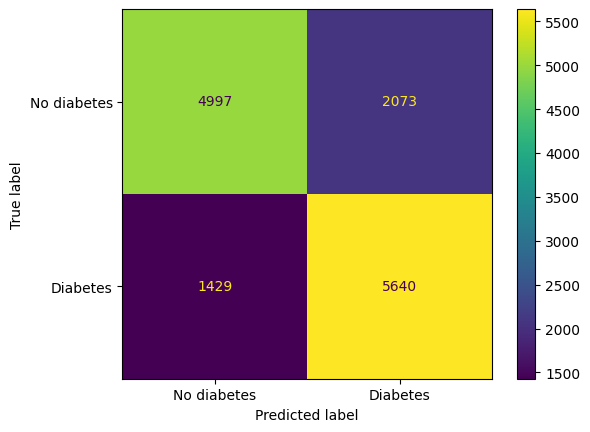

In [ ]:
# Crear el modelo con los mejores hiperparámetros obtenidos
classifier = XGBClassifier(
    seed=42,
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    min_child_weight=study.best_params['min_child_weight'],
    gamma=study.best_params['gamma'],
    n_estimators=study.best_params['n_estimators']
    )

# Variables a escalar
col_to_scale=['Age', 'BMI', 'GenHlth', 'MentHlth','PhysHlth']


# Transformador de columnas del pipeline
col_transformer = ColumnTransformer(transformers=[
    ('minmax', MinMaxScaler(), col_to_scale)],
                                    remainder='passthrough',
                                    verbose_feature_names_out=False)
set_config(transform_output='pandas')
# Definición del Pipeline
pipe = Pipeline(steps=[
    ('column_transformer', col_transformer),
    ('classifier', classifier)
    ])

# Entrenamiento del modelo
pipe.fit(X_train, y_train)

# Guarda el mejor pipeline en un archivo .pkl
joblib.dump(pipe, 'classifier_optimizado.pkl')

# Predicción y evaluación del modelo con la métrica de f1-score
y_pred = pipe.predict(X_test)

# Matriz de confusión
confussion_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confussion_matrix, display_labels=["No diabetes", "Diabetes"])
disp.plot()

# Reporte de métricas
report = classification_report(y_test, y_pred)
print('XGBoost classification report:\n', report)

El método de optimización arrojó un F1-Score ponderado de aproximadamente 0.75. Este puntaje no refleja un rendimiento satisfactorio para un modelo destinado a detectar una enfermedad tan crucial como la diabetes.

Con el fin de profundizar en la capacidad de generalización del modelo, se generó su matriz de confusión correspondiente. A partir de esta matriz, se observó que los errores de clasificación representaban un poco más de una cuarta parte en ambas clases. Además, se evidenció la ausencia de sesgo hacia alguna de las clases. Aunque los errores de clasificación son menores que las clasificaciones correctas, su frecuencia sigue siendo alta para problemas médicos, donde se espera minimizar al máximo los errores de clasificación. Sin embargo, no se identificó una solución sencilla para mejorar el modelo.

Por último, las métricas empleadas para evaluar la predictibilidad del modelo no aseguran una buena selección de características, ya que `XGBoost` no realiza una selección automática de estas. Esto implica que el modelo no descarta automáticamente características menos relevantes o ruidosas, lo que puede llevar a ajustarse al ruido específico del conjunto de datos.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

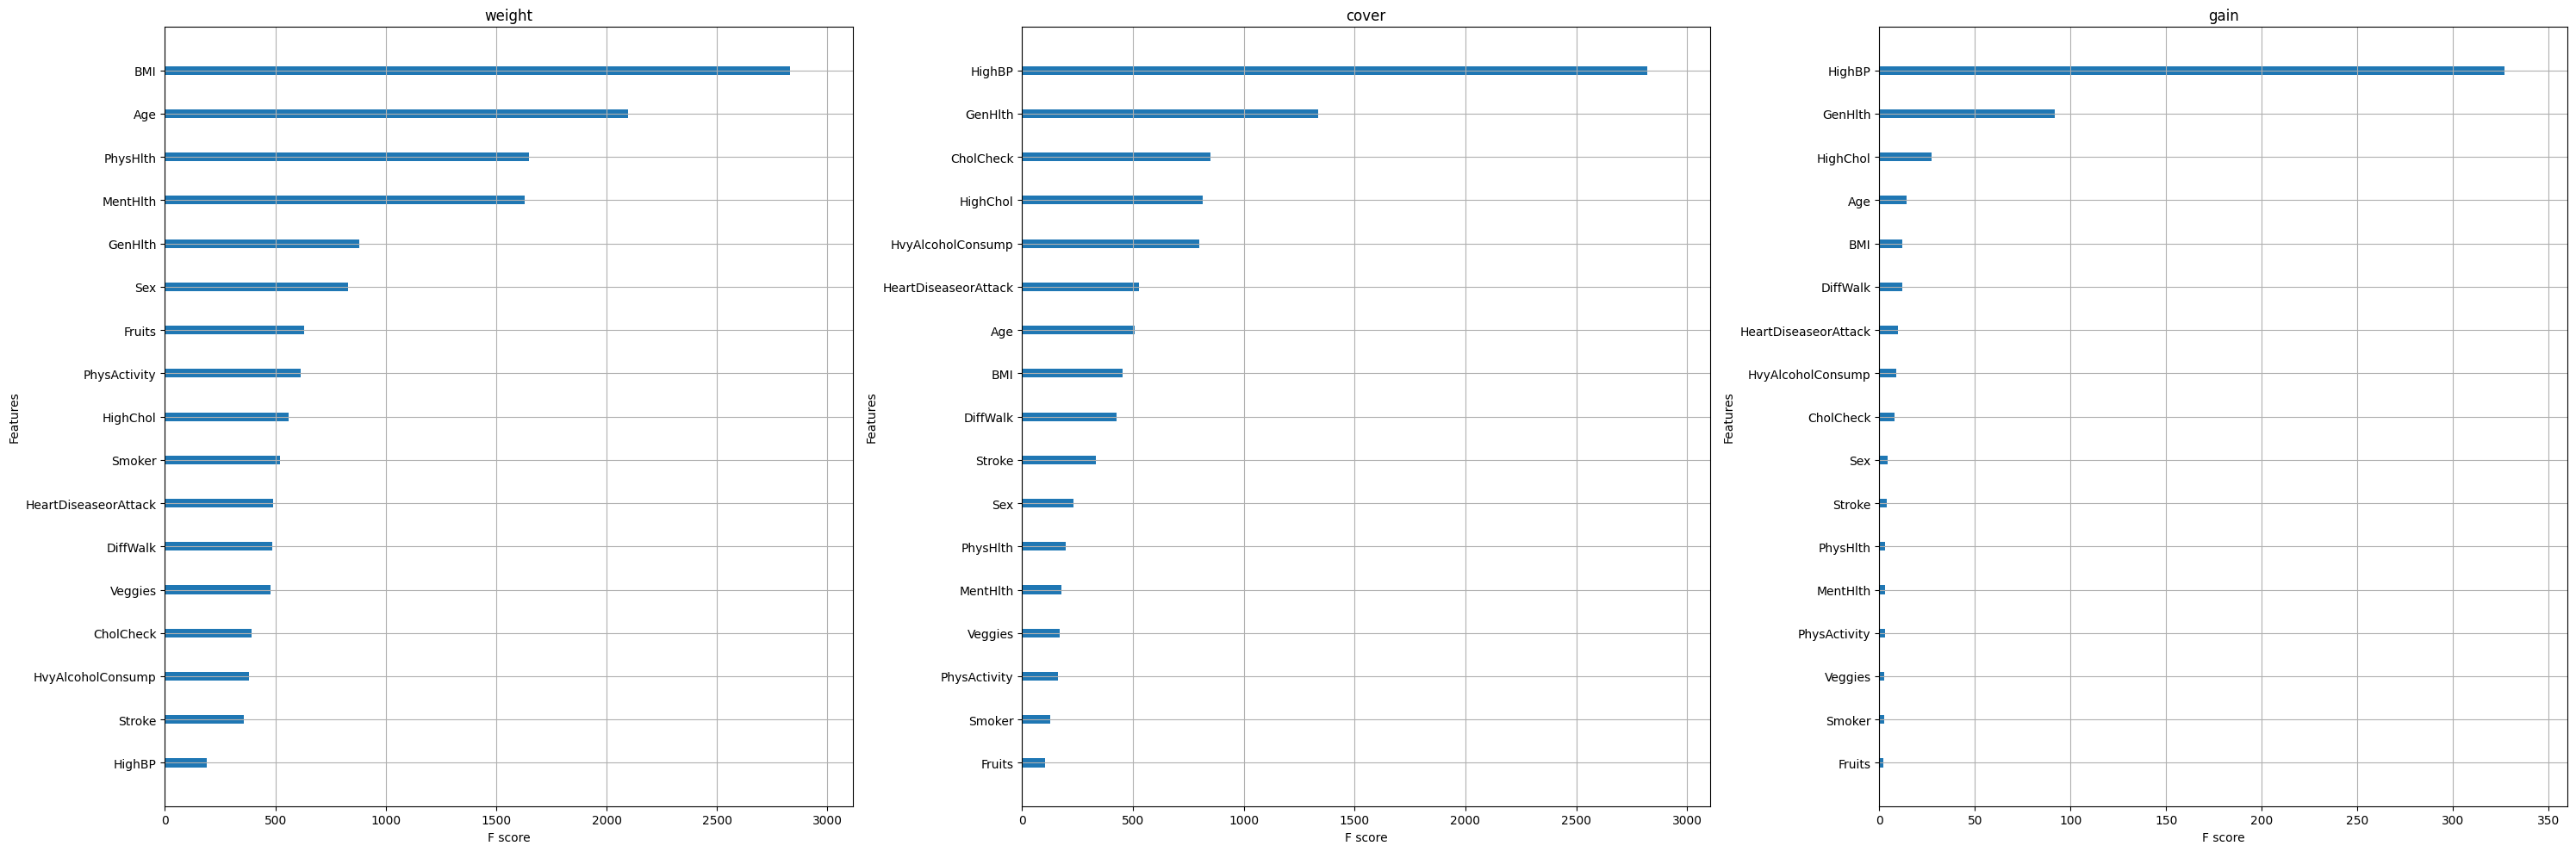

In [ ]:
# Visualización de la importancia de las features
fig, axes = plt.subplots(ncols=3, figsize=(30, 10))
importance_types = ("weight", "cover", "gain") # Métodos de xgboost
# Grafica cada uno de loa métodos
for method, ax in zip(importance_types, axes):
    xgb.plot_importance(
        classifier, importance_type=method, title=method, ax=ax, show_values=False
    )
plt.tight_layout()

Primero que todo, para poder realizar un correcto análisis de estos se resultados se deberá entender la definición de cada uno de los tre métodos graficados:

- **weight**: Representa la frecuencia con la que una característica aparece en
 todos los árboles del modelo. Básicamente, cuenta las veces que una característica se usó para dividir los árboles, lo que señala su relevancia en términos de su uso frecuente.

 En este contexto, cuando una característica, como la variable `BMI`, ocupa el primer lugar en este método, indica que fue la más utilizada para realizar divisiones durante el entrenamiento. Esto sugiere su alta relevancia para la toma de decisiones y la separación de clases en el conjunto de datos. Por el contrario, cuando una característica, como `HighBP`, se ubica en el último lugar, muestra que fue la menos utilizada para las divisiones durante el entrenamiento del modelo.

- **cover**: Muestra la cobertura relativa de una característica en los  
 árboles, calculada como la suma de la importancia de la característica en cada árbol. Indica la cantidad de datos afectados por las decisiones basadas en esa característica.

 En este contexto, cuando una característica, como la variable `HighBP`, se encuentra en el primer lugar, indica que esa característica tiene la mayor cobertura relativa en los árboles del modelo. En otras palabras, esa característica afecta a la mayor cantidad de datos en términos de las decisiones tomadas en los árboles durante el entrenamiento. Esto sugiere que la característica tiene una gran influencia en la toma de decisiones del modelo y afecta a una parte significativa del conjunto de datos. Por otro lado, cuando una característica se encuentra en el último lugar, como `Fruits`, significa que esa característica tiene la menor cobertura relativa en los árboles del modelo. Esto indica que la característica afecta a una cantidad mínima de datos en comparación con otras características durante el proceso de toma de decisiones del modelo.

- **gain**: Refleja la ganancia promedio de impureza que cada característica
 aporta al modelo al ser utilizada en las divisiones de los árboles. Cuanto mayor sea el valor de ganancia, más influye la característica en la mejora de la pureza de las divisiones.

 En este contexto, cuando una característica, como `HighBP`, se encuentra en el primer lugar, indica que esa característica aporta la mayor ganancia en términos de la mejora de la pureza de las divisiones en los árboles del modelo. En otras palabras, esa característica es la más relevante para mejorar la capacidad del modelo para discriminar entre las clases en el conjunto de datos. Por otro lado, cuando una característica, como `Fruits`, está en el último lugar, indica que esa característica proporciona la menor ganancia en términos de mejora de la pureza de las divisiones en los árboles del modelo. Esto sugiere que la característica tiene un impacto mínimo en la capacidad del modelo para separar las clases en comparación con otras características.

Los resultados de los métodos revelan que ninguna característica mantiene la misma posición en los tres métodos; como máximo, algunas se mantienen en dos métodos. Por ejemplo, `HighBP` ocupa el primer lugar y `Fruits` se posiciona en último lugar en los métodos `cover` y `gain`, respectivamente.

A pesar de las discrepancias entre los métodos, se observan patrones consistentes. Por ejemplo, `HighCol` se mantiene en posiciones elevadas en los tres métodos, mientras que `Veggies` tiende a ubicarse en posiciones bajas en todos ellos. Por otro lado, `HearthDiseaseorAttack` y `HvyAlcoholConsump` muestran una alta variabilidad entre los métodos.

En respuesta a las preguntas planteadas, las importancias obtenidas no son suficientes para lograr la interpretabilidad en un modelo basado en árboles. Si bien proporcionan una indicación global de la importancia de cada característica, no permiten reconstruir el proceso de toma de decisiones del modelo. A diferencia de un árbol de decisión, que ofrece interpretabilidad global (mediante la visualización de su estructura) y local (seguimiento de un camino hacia una hoja), este modelo carece de esa precisión. Además, su debilidad radica en la interpretación inexacta y sesgada; no revela la dirección de la relación de una característica con la probabilidad de diabetes ni muestra la distribución específica de cada variable.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

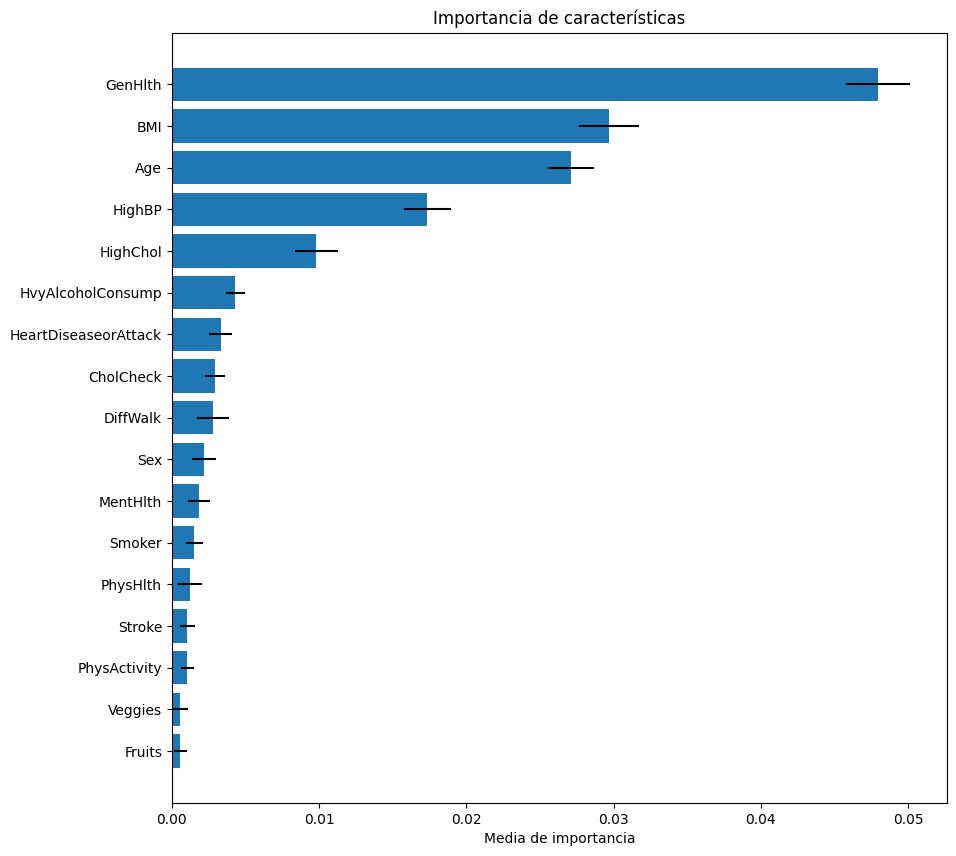

In [ ]:
# Transformación MinMaxScaler del conjunto de test
set_config(transform_output='pandas')
X_test_transformed = pipe['column_transformer'].transform(X_test)

# Implementación de método de permutación
perm_importance = permutation_importance(
    classifier, X_test_transformed, y_test, n_repeats=30, random_state=42, n_jobs=-1
)

# Registra la media y la desviación estándar de los resultados en un DataFrame
perm_importance_df = pd.DataFrame(
    {
        "importances_mean": perm_importance.importances_mean,
        "importances_std": perm_importance.importances_std,
    },
    index=X_test_transformed.columns,
).sort_values(by="importances_mean", ascending=True)

# Gráfica la media y la desviación estándar de cada variable
plt.figure(figsize=(10, 10))
plt.barh(
    range(X_test_transformed.shape[1]),
    perm_importance_df.importances_mean,
    xerr=perm_importance_df.importances_std,
)
plt.yticks(range(perm_importance_df.shape[0]), perm_importance_df.index)
plt.title("Importancia de características")
plt.xlabel("Media de importancia");


El método de `permutation_importance` evalúa la importancia de las características al permutar aleatoriamente sus valores y observar su impacto en el rendimiento del modelo. Al modificar aleatoriamente cada característica y mantener constantes los demás aspectos del modelo, calcula cuánto varía la métrica de rendimiento.

En el gráfico, se presentan dos métricas de importancia. La primera, representada por las barras, es la media de las importancias. Esta medida indica el cambio promedio en la métrica de desempeño al permutar los valores de cada característica. A mayor disminución en la métrica al permutar una característica, mayor es su importancia promedio.

La segunda medida se visualiza mediante líneas en los extremos de las barras, mostrando la desviación estándar. Esta medida refleja la variabilidad o dispersión de las importancias de las características. Una desviación estándar elevada puede sugerir mayor incertidumbre en la evaluación de la importancia. Aunque las permutaciones generalmente deberían empeorar los resultados, la aleatoriedad puede ocasionalmente mejorarlos. Sin embargo, en este caso, la mayoría de las importancias exhiben una baja desviación estándar, lo que indica consistencia en el método de evaluación.

Según los resultados, las 5 features que tienen mayor impacto en la salida del modelo son:

- `GenHlth`: Calificación de la salud en general.

- `BMI`: Índice de Masa Corporal.

- `Age`:  Categoría de edad de 13 niveles organizada en intervalos de 5 años: 1 = 18-24; 2 = 25-29; ...; 9 = 60-64; ...; 13 = 80 o más.

- `HighBP`: Indicador de tener o no presión alta.

- `HighChol`: Indicador de tener o no alto colesterol.

Todas estas variables parecen tener cierta correlación con la diabetes, ya que cuatro de ellas están directamente relacionadas con la salud. Sin embargo, es crucial aclarar que esta correlación no implica una relación causal directa con la presencia de diabetes, sino más bien una alta asociación con la clasificación de la enfermedad en este contexto.

Al profundizar en la relación de estas características con la diabetes:

- `BMI` (Índice de Masa Corporal) se vincula con la obesidad, un factor asociado con la diabetes tipo 2.
- `Age` (Edad) resulta relevante, ya que la incidencia de diabetes tiende a incrementarse con el envejecimiento.
- `HighBP` (Presión Alta) y `HighChol` (Alto Colesterol) representan factores de riesgo para la diabetes.

Por otro lado, la inclusión de `GenHlth` (Calificación de Salud en General) podría ser significativa, ya que refleja la percepción subjetiva de la salud del individuo, pudiendo correlacionarse con factores subyacentes de riesgo de diabetes.

Sin embargo, a pesar de ser las features más importantes según el método, para una evaluación más precisa y completa, se requiere mayor información detallada del conjunto de datos.

Al comparar este ranking de características con el obtenido mediante los métodos anteriores de `plot_importance`, se observan similitudes y algunas discrepancias reveladoras. Se mantienen ciertas consistencias, como las posiciones bajas de las variables `Fruits` y `Veggies`, así como la constante presencia de `HighChol` en posiciones altas en ambos enfoques. Sin embargo, se destacan diferencias notables: en modelos anteriores, `HighBP` ocupaba consistentemente una de las primeras posiciones, mientras que ahora se sitúa en la cuarta posición. Además, variables como `HvyAlcoholConsump`, `HearthDiseaseorAttack` y `CholCheck` ocupan posiciones altas en este método, a diferencia de su ubicación más baja en el enfoque anterior. En general, las cinco características principales se mantienen en la mayoría de los métodos, pero varía su orden entre ellos.


Algunas de las `ventajas` del método implementado son:
- Toma en cuenta las interacciones entre features. Puede capturar interacciones entre características, ya que evalúa la contribución individual de cada característica al rendimiento general del modelo.
- No requiere suposiciones sobre la distribución de los datos, lo que lo hace aplicable a una amplia variedad de modelos y conjuntos de datos.
-  Es una técnica aplicada posterior al entrenamiento que no altera la estructura del modelo, permitiendo evaluar la importancia de las características sin afectar el proceso de entrenamiento ni provoca que se reentrene.

Algunas de las `desventajas` del método implementado son:
- Puede ser computacionalmente costoso, especialmente en modelos complejos o con un gran número de features, ya que requiere múltiples evaluaciones del modelo al permutar cada característica.
- La importancia de cada característica puede verse afectada por las permutaciones de otras características altamente correlacionadas, lo que podría introducir sesgos en la evaluación de la importancia.
-En modelos complejos con múltiples niveles de interacciones y transformaciones no lineales, la interpretación de la importancia de las características puede resultar desafiante o poco precisa.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.5 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

Se calcularon los `shap values` para todo el conjunto de datos en lugar de limitarse al conjunto de test, como se suele observar en algunos ejemplos. Esto se hizo con la intención de estar preparados para explicar instancias específicas que podrían encontrarse tanto en el conjunto de entrenamiento como en el de test, dependiendo de cómo se hayan dividido los datos. Asimismo, se eligió utilizar un explainer de arboles debido a la naturaleza del método de XGBoost, en este caso `XGBClassifier`.

In [ ]:
import shap
# Transformación MinMaxScaler del conjunto de test
set_config(transform_output='pandas')
X_transformed = pipe['column_transformer'].transform(features)

# Aplicación de explainer de arboles para el modelo de xgboost
explainer = shap.TreeExplainer(pipe['classifier'], feature_names=pipe['column_transformer'].get_feature_names_out())
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(X_transformed)

# Guarda los valores de shap en un DataFrame
shap_values_df = pd.DataFrame(shap_values, columns=X_transformed.columns, index=X_transformed.index)
shap_values_df.head(5)

[03:46:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


,Age,BMI,GenHlth,MentHlth,PhysHlth,Sex,HighChol,CholCheck,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,DiffWalk,Stroke,HighBP
0,-0.835560,-0.210290,0.199259,-0.063732,0.182256,0.024699,-0.337010,0.015401,0.014414,-0.043677,-0.004952,-0.000821,-0.010673,0.027817,-0.040418,-0.009275,0.422253
1,0.264206,-0.247757,0.203686,0.014168,0.001246,0.051139,0.175887,0.012617,-0.000345,-0.032595,0.037804,-0.003739,0.035563,0.028435,-0.053815,0.152899,0.322870
2,0.684447,-0.211223,-1.059212,0.015724,0.146621,0.200352,-0.195963,0.012652,-0.011385,-0.035519,-0.040010,-0.031713,-0.010591,0.019382,-0.043840,-0.012509,-0.501145
3,0.288691,-0.108178,0.236549,0.006199,0.003380,0.054166,0.212106,0.012630,0.002099,-0.030576,-0.011744,-0.006783,-0.012507,0.024573,-0.060469,-0.004625,0.326265
4,-0.046910,0.197631,-0.600290,0.053790,0.009624,-0.103177,-0.227424,0.025119,0.006463,-0.037002,-0.014509,-0.010201,-0.011512,0.020520,-0.048216,-0.010916,-0.497788


En esta interpretación, un valor positivo de `shap values` indica que incrementos en la característica están asociados con un aumento en la probabilidad de tener diabetes, mientras que un valor negativo sugiere que incrementos en la característica se relacionan con una disminución en la probabilidad de tener diabetes. Es común encontrar que una variable posea valores tanto positivos como negativos, dado que el modelo no es lineal. Esta diversidad implica que para algunos pacientes, una característica puede aumentar la probabilidad de diabetes, mientras que para otros, el mismo valor en esa característica puede disminuir esta probabilidad.

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¿Existe algún patrón común entre las instancias analizadas?
- ¿Es posible generalizar estas conclusiones a todo el dataset?

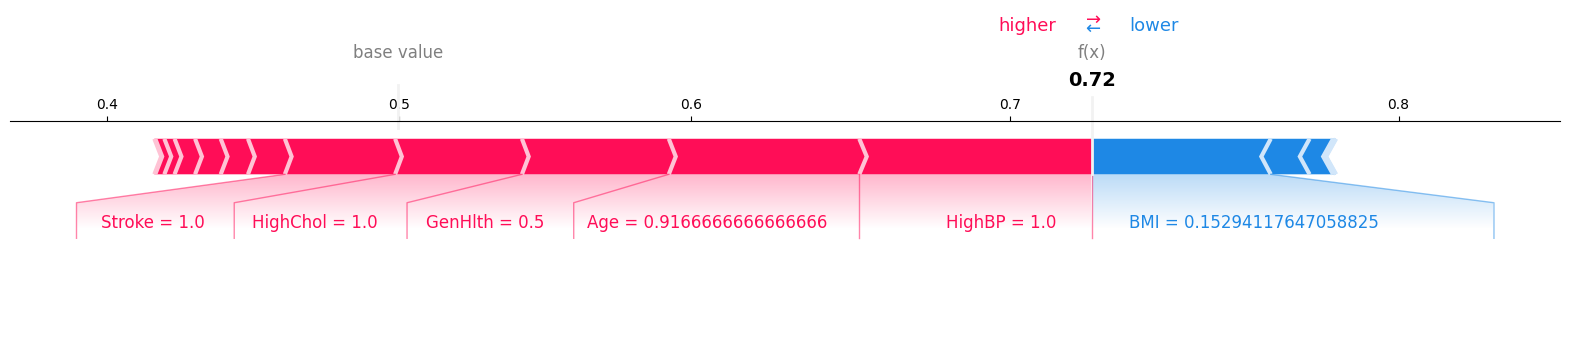

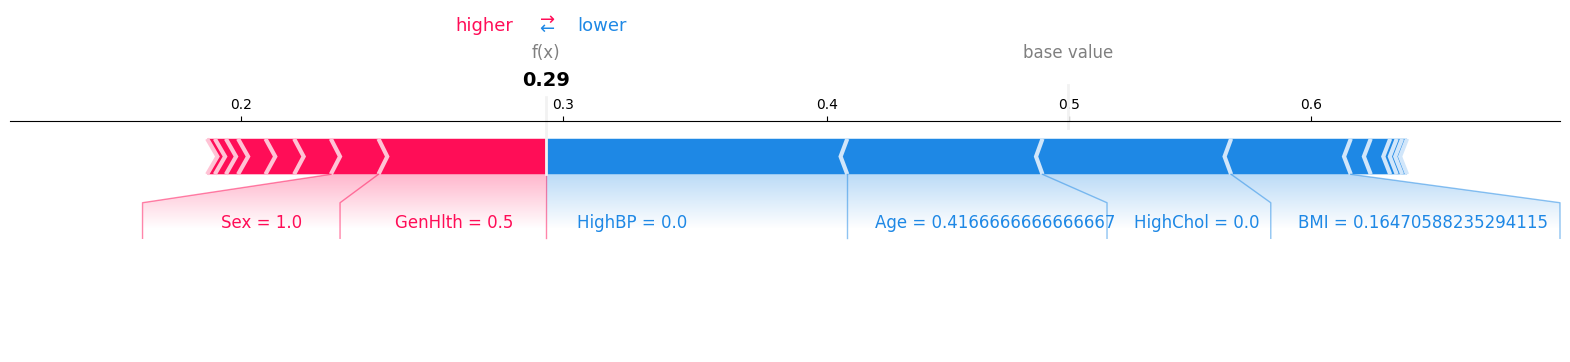

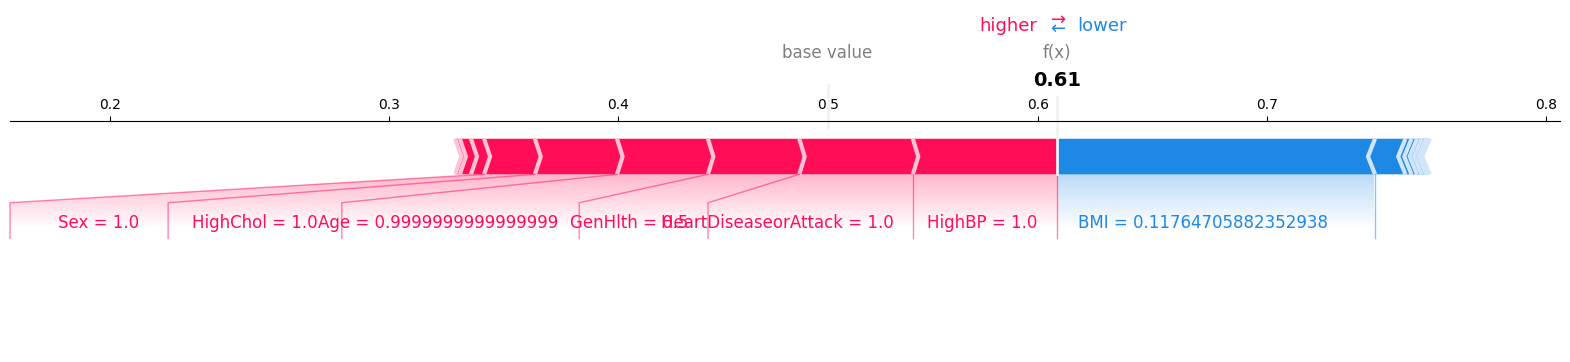

In [ ]:
id_instancias = [1, 9, 150] # índices de las instancias
instancias = X_transformed.iloc[id_instancias, :] # Extracción de instancias de interés
valores = shap_values[id_instancias, :] # Shap values de cada instancia de interés

# Grafico del aporte de cada instancia
for instancia, valor in zip(instancias.iterrows(), valores):
    shap.force_plot(
        explainer.expected_value,
        valor,
        instancia[1],
        # Evita el output de Javascript
        matplotlib=True,
        # Entrega probabilidad en la salida
        link="logit",
    )

- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
 Analizando cada una de las instancias por separado se puede observar lo siguiente:
  - **Instancia 1**:   
      - **Positiva**: `Stroke`, `HighChol`, `GenHlth`, `Age` y `HighBP`. Esto se puede interpretar como que el haber sufrido un ataque cerebrovascular, tener colesterol alto, calificarse con una salud general "buena", pertener al grupo 12 de edades, es decir  entre 75 años y 79 años de edad y tener la presión alta aumentan la probabilidad de que este paciente sufra de diabetes.

      - **Negativa**: `BMI`. Disminuye la probabilidad de tener diabetes el hecho de que el paciente tenga un BMI de 26% .
  
  - **Instancia 9**:   
      - **Positiva**: `Sex` y `GenHlth`. Aumenta la probabilidad de tener diabetes el hecho de que el paciente sea hombre y se califique su salud general como "buena".

      - **Negativa**: `HighBP`, `Age`, `HighChol` y `BMI`. Disminuye la probabilidad de tener diabetes el hecho de que el paciente no tenga la presión alta,  pertener al grupo 6 de edades, es decir estar entre los 45 años y 49 años de edad, el no tener un alto colesterol y tener un BMI de 27% .
  
  - **Instancia 50**:   
      - **Positiva**: `Sex`, `HighChol`, `Age`, `GenHlth`, `HearthDiseaseorAttack` y `HighBP`. Aumenta la probabilidad de tener diabetes el hecho de que el paciente sea hombre, tenga colesterol alto, pertenecer al grupo 13 de edades, es decir ser mayor de 80 años, calificarse con una salud general "buena", haber sufrido un enfermedad coronaria o infarto al miocardio y tener una presión alta.

      - **Negativa**: `BMI`. Disminuye la probabilidad de tener diabetes el hecho de que el paciente tenga un BMI de 23%.

- ¿Existe algún patrón común entre las instancias analizadas?
   
   Durante el análisis de las tres instancias seleccionadas, se identificaron patrones significativos. Por ejemplo, en los tres casos, la variable `GenHlth` se mantuvo constante con un valor de 3, indicando que los pacientes calificaron su salud general como "buena". Este factor se asoció con un aumento en la probabilidad de tener diabetes en los tres escenarios analizados. También se destacó la relevancia de la edad en esta probabilidad: a medida que la edad aumenta, se convierte en un factor que incrementa la probabilidad de padecer diabetes, como se evidenció en las instancias 1 y 50, mientras que ser más joven pareció reducir esta probabilidad, como se observó en la instancia 9. Además, se notó la influencia del `BMI`: tener un valor cercano al primer cuartil se vinculó con una disminución automática en la probabilidad de diabetes. Por último, ser hombre y tener altos niveles de colesterol surgieron como factores que aumentaron la probabilidad de sufrir diabetes.

- ¿Es posible generalizar estas conclusiones a todo el dataset?
   
   No, las conclusiones extraídas a partir de los resultados de los `shap values` son interpretaciones locales y aplicables únicamente a las instancias específicas visualizadas en esta pregunta.

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

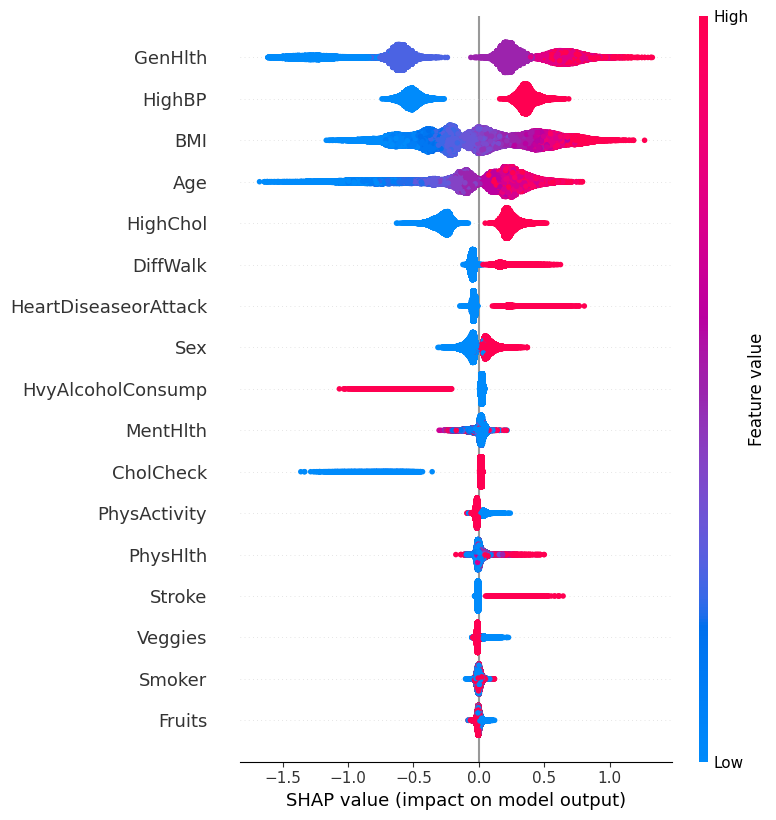

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Grafico de importancias relativas a nivel global
    shap.summary_plot(shap_values, X_transformed)

El gráfico anterior proporciona una visualización de las importancias relativas de todas las variables presentes en el conjunto de datos. Cada característica se representa mediante un conjunto de puntos que simbolizan los datos, y sus tonalidades reflejan sus valores respectivos. Los tonos más rojizos denotan valores altos, mientras que los tonos más azulados indican valores bajos. Esta representación permite percibir cómo se distribuye la importancia de estas características, así como el impacto positivo o negativo que tienen los valores altos o bajos de cada una de ellas. El patrón y la dispersión de estos puntos brindan una idea visual de la influencia y variación de estas características en las predicciones del modelo.

En varias variables binarias como `HighBP`, `HighCol`, `DiffWalk`, `HeartDiseaseorAttack`, `Sex`, `HvyAlcoholConsump`, `CholCheck` y `Stroke`, se observan dos grupos de valores, mostrando efectos positivos y negativos, independientes de otras variables. Es razonable esperar que los pacientes con alta presión sanguínea tengan un aumento de la probabilidad de diabetes (y viceversa), pero este efecto puede ser no lineal al combinarse con otros factores.

Respecto a `CholCheck`, se aprecia una mayor variabilidad para aquellos con valor 0.0, presentando distintas magnitudes de disminución de probabilidad, mientras que para aquellos con valor 1.0, se observa un ligero aumento. En contraste, `HvyAlcoholConsump` muestra una gran variabilidad para valores con valor 1.0, con distintas magnitudes de disminución de probabilidad, pero cuando su valor es 0.0, el aumento de la probabilidad se reduce significativamente.  Lo que entrega un resultado curioso, ya que indica que si se consume alcohol disminuiría la probabilidad de contraer diabetes.

En cuanto a variables como `MentHlth`, `PhysActivity`, `PhysHlth`, `Veggies`, `Smoker` y `Fruits`, parece que su relevancia en las decisiones del modelo es limitada. Sus valores de SHAP son pequeños y muestran efectos confusos, especialmente al presentar magnitudes similares con impactos de signo opuesto. Esta tendencia es más notoria en las dos últimas variables, `Smoker` y `Fruits`.

La relación entre los valores de SHAP y la variable `GenHealth` no sigue una tendencia monótona. Sin comprender la distribución de la variable, resulta difícil determinar si coincide con la interpretación local.

Observamos que persisten patrones similares a los de la pregunta anterior, como la asociación entre edades más jóvenes y valores de SHAP más bajos, así como la influencia del género (sexo 1) que conlleva valores de SHAP más altos.

No se identifican diferencias significativas en la interpretación local solo a partir del gráfico. Se percibe que el valor de `Veggies` tiene poca relevancia en general y exhibe una relación no monótona discontinua peculiar.

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

Se definirá una función que permitirá transformar los valores de SHAP a una probabilidad.

In [ ]:
def shap_prob(shap_value):
  """Convierte un valor de SHAP a una probabilidad.

  Parameters:
  ----------------
  shap_value: float
         Valor de SHAP a transformar a probabilidad.

  Returns:
  ----------------
  prob_shap: float
        Valor de SHAP transformado a probabilidad.
  """

  odd_shift = np.exp(shap_value)
  prob_shap = odd_shift / (1 + odd_shift)
  return prob_shap

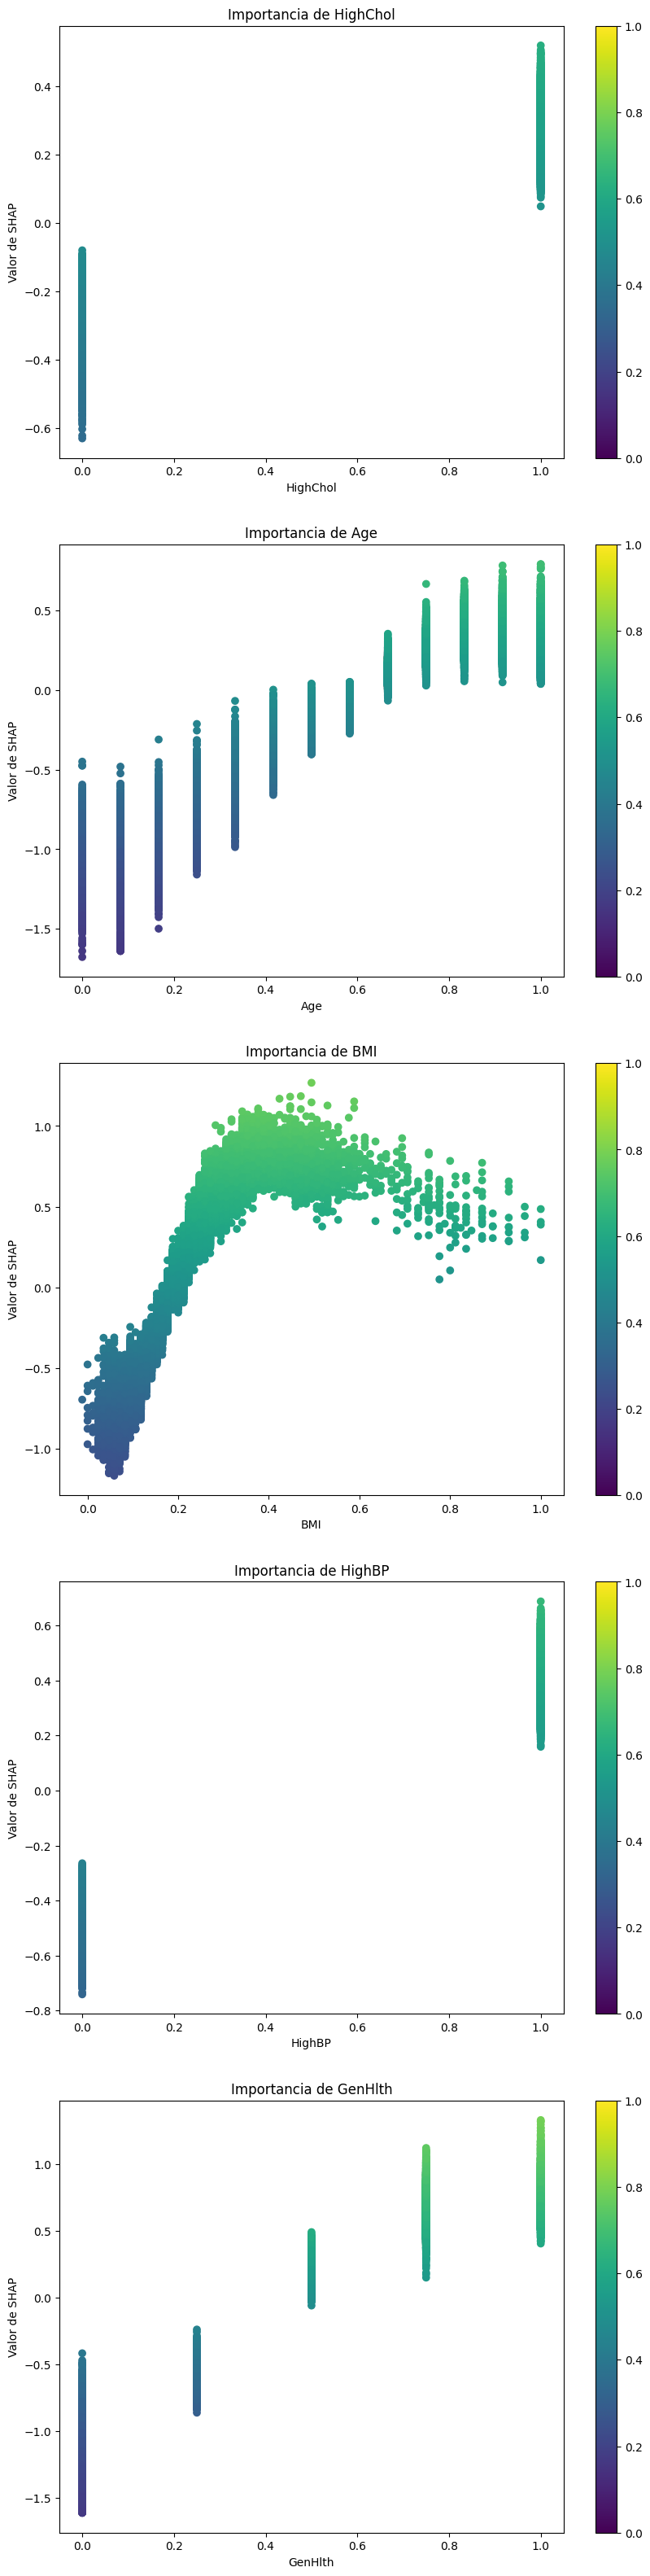

In [ ]:
top_features = 5 # Graficar las 5 primeras features
# Obtención de los índices a partir de las medias de los valores de SHAP ordenadas
indexes = np.argsort(np.abs(shap_values).mean(0))[-top_features:]
# Grafica los scatter plots para cada feature seleccionada
fig, axes = plt.subplots(nrows=top_features, figsize=(10, 8 * top_features))
for ax, feature in zip(axes, indexes):
    # Extracción de los valores de SHARP para cada feature
    shap_x = shap_values[:, feature]
    # Generación del scatter plot
    scatter = ax.scatter(
        X_transformed.iloc[:, feature], shap_x, c=shap_prob(shap_x), vmin=0.0, vmax=1.0
    )
    ax.set_xlabel(X_transformed.columns[feature])
    ax.set_ylabel("Valor de SHAP")
    ax.set_title(f"Importancia de {X_transformed.columns[feature]}")
    fig.colorbar(scatter)

En el análisis de las relaciones entre los valores SHAP y las variables, se identifica que ninguna relación sigue un patrón estrictamente monótono. No obstante, en cuatro de las variables (todas categóricas, excepto `BMI`), el valor promedio del SHAP por cada categoría muestra una tendencia creciente. Esto sugiere que, en términos generales, estas cuatro características tienden a incrementar la probabilidad de diabetes a medida que sus valores aumentan. Este fenómeno se hace más evidente al analizar las variables `HighBP` y `HighChol`, las cuales tienen únicamente dos valores (0.0 y 1.0). Se observa que cuando estas variables tienen el valor mínimo, la probabilidad de diabetes tiende a ser baja, mientras que al alcanzar su valor máximo, la probabilidad asciende significativamente.

La variable `Age` presenta claramente las probabilidades dentro de los 13 grupos de edad distintos, evidenciando una tendencia creciente en la probabilidad de tener diabetes a medida que la edad avanza. Sin embargo, lo más notable radica en la variabilidad de los intervalos de probabilidad en cada grupo. Se destaca que en los grupos de edades más tempranas, la dispersión en las probabilidades es considerablemente mayor en comparación con los grupos de edades más avanzadas. Específicamente, se observa la mínima variabilidad en el grupo 8, abarcando el rango de edades entre 55 y 59 años.

La variable `GenHlth` muestra claramente las 5 clases asociadas a la calificación que los pacientes asignan a su salud general. Se observa que a medida que la calificación empeora, es decir, a medida que la clase aumenta, la probabilidad de tener diabetes tiende a aumentar. Por el contrario, cuando la calificación se acerca a un estado de excelente salud (valor 1), la probabilidad de diabetes disminuye.

Por último, en el caso de `BMI`, la relación parece tener un comportamiento cuadrático con un coeficiente principal negativo. Se observa un punto máximo en torno al 40% de BMI, pero para valores más bajos hay algunos valores más altos de SHAP. Esto podría relacionarse con la prevalencia de diabetes tipo 1 en individuos más jóvenes, quienes tienden a tener bajo peso, explicando este cambio inicial en la pendiente. Sin embargo, posteriormente, la probabilidad disminuye, lo cual es algo inesperado. Esta parte del análisis muestra una dispersión considerable en los datos, especialmente después del punto máximo, lo que sugiere que el modelo ha aprendido de manera deficiente esta área de la población. Este sesgo en los datos capturado por el modelo podría ser una preocupación importante a considerar.

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

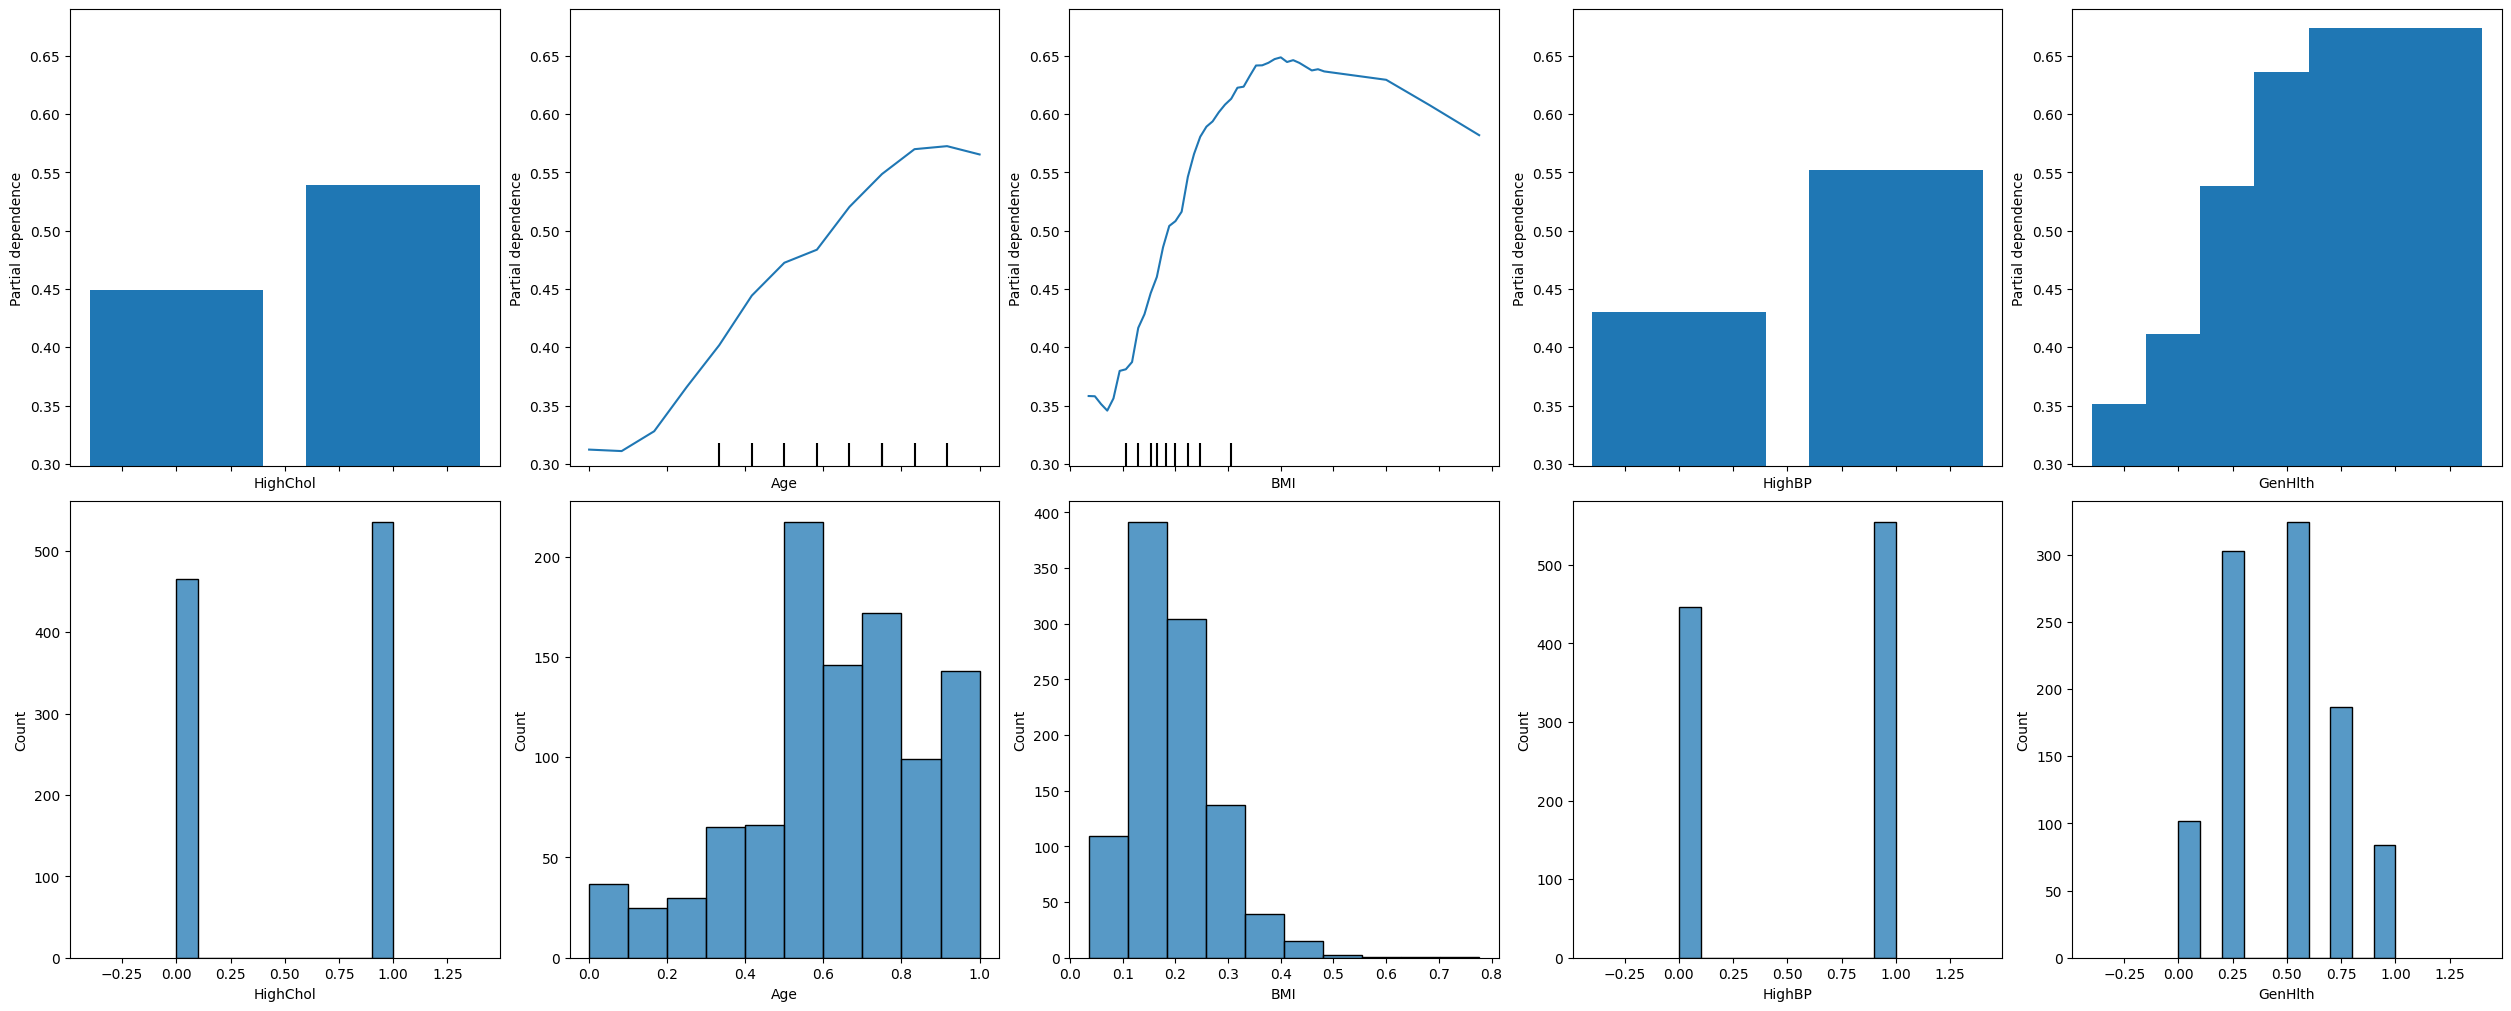

In [ ]:
categorical_features = ["HighChol", "HighBP", "GenHlth"] # Variables categóricas del top 5
best_five_cols = X_transformed.columns[indexes] # Todas las variables del top 5
submuestra = resample(X_transformed, n_samples=1000, random_state=0, stratify=labels) # Submuestra de 1000 observaciones

fig, ax = plt.subplots(
    ncols=5, nrows=2, figsize=(25, 10), constrained_layout=True, sharex="col"
)

# Generamos las Partial Dependence Plots para las 5 variables
display = PartialDependenceDisplay.from_estimator(
    pipe['classifier'], submuestra, best_five_cols, ax=ax[0], categorical_features=categorical_features,
)

# Graficamos histogramas para las 5 variables
for i, feature in enumerate(best_five_cols):
    sns.histplot(
        data=submuestra,
        x=feature,
        ax=ax[1, i],
        multiple="stack",
        bins=10,
    )

En estos gráficos, observamos relaciones similares a las presentadas por los valores de SHAP, aunque resumidas en importancias promedio. Para muchas características, esto no aporta novedades significativas, pero en el caso del `BMI` , se hace más evidente la reducción de la probabilidad para valores muy altos y su aumento para valores muy bajos, mostrando un comportamiento creciente y monótono en el rango intermedio.

- ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada?
 Las relaciones entre la salida promedio del modelo y cada característica analizada se presentan en estos gráficos. En estos gráficos de la característica $j$, un punto $(x_j, y)$ representa que el valor promedio de la salida del modelo para instancias con el valor $x_j$ en la característica $j$ es $y$.

- ¿Son estas conclusiones generalizables para todo el conjunto de datos?

 Sí, estas interpretaciones son globales y ofrecen una visión del comportamiento promedio de los datos. No obstante, es importante recordar que los promedios reflejan una medida de tendencia central y no revelan información sobre la dispersión de la dependencia parcial. Asimismo, hay que tener en cuenta algunas de las desventajas que presenta este método, por ejemplo, el maximo número de features que podemos plotear, la suposición de independencia de las variables, los efectos heterogéneos podrían estar ocultos, etc.

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from alibi.explainers import AnchorTabular

2023-06-16 03:21:35.062920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 03:21:35.266905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-16 03:21:35.266966: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-16 03:21:35.308521: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-16 03:21:38.061257: W tensorflow/stream_executor/platform/de

In [ ]:
# Train the explainer
predict_fn = lambda x: pipe.named_steps['classifier'].predict(x)
explainer = AnchorTabular(predict_fn, col_transformer.get_feature_names_out(), seed=1)

# Transform the data before fitting (optional, depending on whether AnchorTabular supports transformed data)
X_train_transformed = col_transformer.transform(X_train)

explainer.fit(X_train_transformed.to_numpy())

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 1, 'disc_perc': (25, 50, 75)},
  'version': '0.9.4'}
)

In [ ]:
class_names = ["No diabetes", "Diabetes"]

idx = 1000
# explicar predicción idx 1000
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  Diabetes
Anchor: GenHlth > 0.75 AND HighBP > 0.00
Precision: 0.97
Coverage: 0.06


La regla indica que la predicción de "diabetes" es particularmente influenciada cuando la puntuación de "GenHlth" (evaluación de la salud general) es mayor que 0.75 y la presión arterial (HighBP) es mayor que 0.00. Es decir, segun esta regla, si una persona es poco saludable (mayor a 0.75) y si tiene presión alta (mayor a cero y por tanto igual a 1) se puede decir que el peciente tiene diabetes.

El coverage y precision, indica que esta regla es aplicable a 6% de los datos con una precisión del 0.97.

In [ ]:
idx = 3001
# explicar predicción idx 3001
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  Diabetes
Anchor: GenHlth > 0.75 AND HighBP > 0.00
Precision: 0.98
Coverage: 0.07


La regla indica que la predicción de "diabetes" es particularmente influenciada cuando la puntuación de "GenHlth" (evaluación de la salud general) es mayor que 0.75 y la presión arterial (HighBP) es mayor que 0.00. Es decir, segun esta regla, si una persona es poco saludable (mayor a 0.75) y si tiene presión alta (mayor a cero y por tanto igual a 1) se puede decir que el peciente tiene diabetes.

El coverage y precision, indica que esta regla es aplicable a 7% de los datos con una precisión del 0.98.

In [ ]:
idx = 5751
# explicar predicción idx 5751
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  No diabetes
Anchor: HvyAlcoholConsump > 0.00 AND BMI <= 0.14 AND HighBP <= 0.00
Precision: 0.99
Coverage: 0.01


La regla indica que la predicción de "no diabetes" es particularmente influenciada cuando la puntuación de el Índice de Masa Corporal (BMI) es menor o igual a 0.14, la de presión arterial (HighBP) es menor o igual a 0.00 (igual a cero) y la de consumo pesado de alcohol (HvyAlcoholConsump) es mayor que 0.00 (esta última puede estar sesgada en la predicción).

El coverage y precision, indica que esta regla es aplicable a 1% de los datos con una precisión del 0.99. Esto indica que la regla es muy específica. Esto explica también el sesgo de la variable HvyAlcoholConsump.

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

Los métodos utilizados, como Anchor Explanations (Reglas), SHAP Values (Agnósticos Locales) y Permutación Feature Importance (Método de Permutación), ofrecen perspectivas complementarias en la interpretación de un modelo de clasificación de diabetes. Anchor proporciona reglas específicas y comprensibles para instancias individuales, destacando condiciones precisas de predicción por otro lado SHAP Values, permite entender la contribución de cada característica en también para instancias particulares. En cambio, el Método de Permutación ofrece una visión global de la importancia relativa de las características en todo el conjunto de pacientes.

Si bien el método de permutación (variables más importantes globalmente) es útil para evaluar la importancia de las características en un modelo de clasificación de diabetes a nivel global y permite obtener conclusiones de todos los datos como conjunto, como en este caso estamos tratando con pacientes (personas individuales), la interpretación local es más importante, esto pues el problema en cuestión es el paciente mismo. Es por esto que los métodos agnósticos locales resultan más útiles para el problema del doctor Simi, pues permite entender las caracterísitcas y las reglas específicas del paciente que llevaron a la predicción de su diagnóstico.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>